In [2]:
# Grammar Scoring Engine for Spoken Data
# Approach to develop a model that scores grammatical accuracy from audio samples

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [4]:
# Define path
TRAIN_AUDIO_PATH = "C:/Users/waghm/Downloads/shl-intern-hiring-assessment/dataset/audios_train/"  # Path to training audio files
TEST_AUDIO_PATH = "C:/Users/waghm/Downloads/shl-intern-hiring-assessment/dataset/audios_test/"    # Path to test audio files
TRAIN_CSV = "C:/Users/waghm/Downloads/shl-intern-hiring-assessment/dataset/train.csv"
TEST_CSV = "C:/Users/waghm/Downloads/shl-intern-hiring-assessment/dataset/test.csv"
SAMPLE_SUBMISSION = "C:/Users/waghm/Downloads/shl-intern-hiring-assessment/dataset/sample_submission.csv"

In [5]:
# Read data
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)
sample_submission = pd.read_csv(SAMPLE_SUBMISSION)

In [6]:
print(f"Training set size: {len(train_df)}")

Training set size: 444


In [7]:
print(f"Test set size: {len(test_df)}")

Test set size: 195


In [8]:
# Explore training data
print("\nTraining data overview:")
print(train_df.head())


Training data overview:
         filename  label
0  audio_1261.wav    1.0
1   audio_942.wav    1.5
2  audio_1110.wav    1.5
3  audio_1024.wav    1.5
4   audio_538.wav    2.0


In [9]:
print("\nTraining data statistics:")
print(train_df.describe())


Training data statistics:
            label
count  444.000000
mean     3.617117
std      1.114151
min      1.000000
25%      2.500000
50%      3.500000
75%      4.500000
max      5.000000


In [10]:
# Read data
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)
sample_submission = pd.read_csv(SAMPLE_SUBMISSION)

In [11]:
print(f"Training set size: {len(train_df)}")

Training set size: 444


In [12]:
print(f"Test set size: {len(test_df)}")

Test set size: 195


In [13]:
# Explore training data
print("\nTraining data overview:")
print(train_df.head())


Training data overview:
         filename  label
0  audio_1261.wav    1.0
1   audio_942.wav    1.5
2  audio_1110.wav    1.5
3  audio_1024.wav    1.5
4   audio_538.wav    2.0


In [13]:
print("\nTraining data statistics:")
print(train_df.describe())


Training data statistics:
            label
count  444.000000
mean     3.617117
std      1.114151
min      1.000000
25%      2.500000
50%      3.500000
75%      4.500000
max      5.000000


In [14]:
print(train_df.columns)

Index(['filename', 'label'], dtype='object')


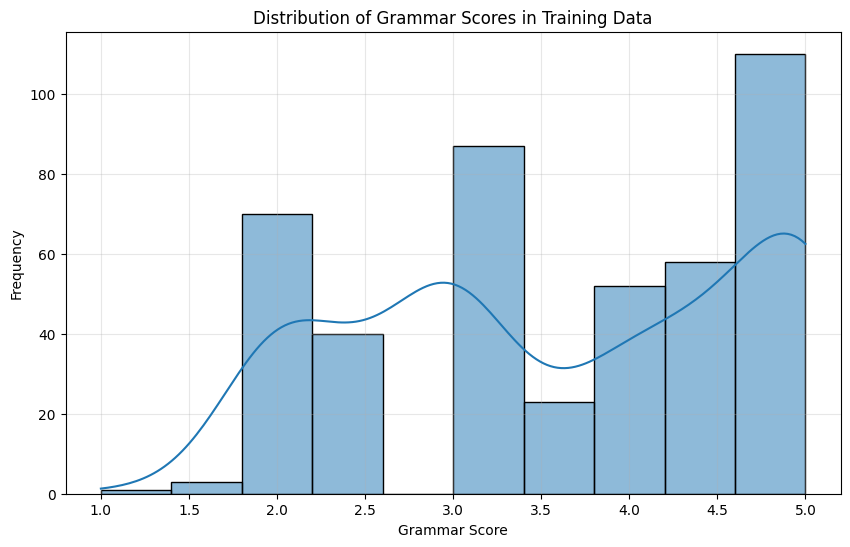

In [15]:
# Plot distribution of grammar scores
plt.figure(figsize=(10, 6))
sns.histplot(train_df['label'], bins=10, kde=True)
plt.title('Distribution of Grammar Scores in Training Data')
plt.xlabel('Grammar Score')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

In [15]:
def extract_features(file_path, max_pad_len=None):
    try:
        y, sr = librosa.load(file_path, sr=16000)
        
        # Extract features
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        pitch = librosa.yin(y, fmin=50, fmax=500)
        
        # Print feature shapes for debugging
        print(f"MFCCs shape: {mfccs.shape}")
        print(f"Spectral Centroid shape: {spectral_centroid.shape}")
        print(f"Spectral Rolloff shape: {spectral_rolloff.shape}")
        print(f"Spectral Bandwidth shape: {spectral_bandwidth.shape}")
        print(f"Zero Crossing Rate shape: {zcr.shape}")
        print(f"Pitch shape: {pitch.shape}")
        
        # Create a feature vector using statistical measures
        feature_vector = []
        
        # Add MFCC features (mean and std for each of the 13 coefficients)
        for i in range(mfccs.shape[0]):
            feature_vector.append(np.mean(mfccs[i]))
            feature_vector.append(np.std(mfccs[i]))
        
        # Add other spectral features (mean and std)
        feature_vector.append(np.mean(spectral_centroid))
        feature_vector.append(np.std(spectral_centroid))
        
        feature_vector.append(np.mean(spectral_rolloff))
        feature_vector.append(np.std(spectral_rolloff))
        
        feature_vector.append(np.mean(spectral_bandwidth))
        feature_vector.append(np.std(spectral_bandwidth))
        
        feature_vector.append(np.mean(zcr))
        feature_vector.append(np.std(zcr))
        
        # Add pitch features
        feature_vector.append(np.mean(pitch))
        feature_vector.append(np.std(pitch))
        feature_vector.append(np.percentile(pitch, 25))  # 1st quartile
        feature_vector.append(np.percentile(pitch, 75))  # 3rd quartile
        
        return np.array(feature_vector)
    
    except Exception as e:
        print(f"Error extracting features from {file_path}: {e}")
        return np.zeros(40)  # Adjust based on the correct feature count

In [16]:
print(os.listdir(TRAIN_AUDIO_PATH))  # Lists all files in audios_train


['audio_1008.wav', 'audio_1017.wav', 'audio_102.wav', 'audio_1024.wav', 'audio_1025.wav', 'audio_1028.wav', 'audio_1030.wav', 'audio_1031.wav', 'audio_1032.wav', 'audio_1036.wav', 'audio_1038.wav', 'audio_104.wav', 'audio_1040.wav', 'audio_1043.wav', 'audio_105.wav', 'audio_1057.wav', 'audio_1059.wav', 'audio_1065.wav', 'audio_1066.wav', 'audio_1069.wav', 'audio_1075.wav', 'audio_1078.wav', 'audio_1082.wav', 'audio_1099.wav', 'audio_110.wav', 'audio_1100.wav', 'audio_1102.wav', 'audio_1103.wav', 'audio_1104.wav', 'audio_1106.wav', 'audio_1110.wav', 'audio_1111.wav', 'audio_1112.wav', 'audio_1114.wav', 'audio_1117.wav', 'audio_1118.wav', 'audio_1120.wav', 'audio_1125.wav', 'audio_1126.wav', 'audio_1128.wav', 'audio_1129.wav', 'audio_1131.wav', 'audio_1134.wav', 'audio_1135.wav', 'audio_1136.wav', 'audio_1147.wav', 'audio_1148.wav', 'audio_1150.wav', 'audio_1153.wav', 'audio_116.wav', 'audio_1160.wav', 'audio_1162.wav', 'audio_1163.wav', 'audio_1164.wav', 'audio_117.wav', 'audio_1171.wav

In [17]:
# Extract features for a sample audio file to check dimensions
sample_file = os.path.join(TRAIN_AUDIO_PATH, train_df['filename'].iloc[0])
if not os.path.exists(sample_file):
    print(f"File not found: {sample_file}")
else:
    print(f"File exists: {sample_file}")
    
sample_features = extract_features(sample_file)
print(f"\nFeature vector shape for one audio file: {sample_features.shape}")

File exists: C:/Users/waghm/Downloads/shl-intern-hiring-assessment/dataset/audios_train/audio_1261.wav
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)

Feature vector shape for one audio file: (38,)


In [18]:
# Create Custom Dataset
class AudioDataset(Dataset):
    def __init__(self, df, audio_dir, transform=None):
        self.df = df
        self.audio_dir = audio_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        audio_path = os.path.join(self.audio_dir, self.df.iloc[idx]['filename'])
        features = extract_features(audio_path)
        
        if 'label' in self.df.columns:
            label = self.df.iloc[idx]['label']
            return torch.FloatTensor(features), torch.FloatTensor([label])
        else:
            return torch.FloatTensor(features), self.df.iloc[idx]['filename']

In [19]:
# Split training data into train and validation sets
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)

# Reset indices
train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)

In [20]:
print(f"\nTraining set size: {len(train_data)}")


Training set size: 355


In [21]:
print(f"Validation set size: {len(val_data)}")

Validation set size: 89


In [22]:
# Create datasets
train_dataset = AudioDataset(train_data, TRAIN_AUDIO_PATH)
val_dataset = AudioDataset(val_data, TRAIN_AUDIO_PATH)  # Validation comes from train data
test_dataset = AudioDataset(test_df, TEST_AUDIO_PATH)   # Test data uses different folder

In [23]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [24]:
# Part 2: Model Definition

class GrammarScorer(nn.Module):
    def __init__(self, input_size):
        super(GrammarScorer, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()  # Output between 0 and 1, will be scaled to 0-5
        )
        
    def forward(self, x):
        return self.model(x) * 5  # Scale output to 0-5 range

In [25]:
# Initialize model
input_size = sample_features.shape[0]  # Number of features
model = GrammarScorer(input_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [26]:
# Part 3: Training and Evaluation Functions

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    
    for inputs, targets in tqdm(train_loader, desc="Training"):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    return running_loss / len(train_loader.dataset)

In [27]:
def evaluate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(data_loader, desc="Evaluating"):
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item() * inputs.size(0)
            
            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    epoch_loss = running_loss / len(data_loader.dataset)
    
    # Calculate additional metrics
    mse = mean_squared_error(all_targets, all_preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(all_targets, all_preds)
    
    return epoch_loss, mse, rmse, mae, all_preds, all_targets

In [37]:
# Part 4: Training Loop

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=50, patience=10):
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_mse': [],
        'val_rmse': [],
        'val_mae': []
    }
    
    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_mse, val_rmse, val_mae, _, _ = evaluate(model, val_loader, criterion, device)
        
        # Save metrics
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_mse'].append(val_mse)
        history['val_rmse'].append(val_rmse)
        history['val_mae'].append(val_mae)
        
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | RMSE: {val_rmse:.4f} | MAE: {val_mae:.4f}")
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_grammar_scorer.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
    
    # Load the best model
    model.load_state_dict(torch.load('best_grammar_scorer.pth'))
    
    return model, history

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

# Move model to device
model = model.to(device)

# Train model
model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=30,
    patience=25
)


Using device: cpu


Training:   0%|                                                                                 | 0/12 [00:00<?, ?it/s]

MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1631)
Spectral Centroid shape: (1, 1631)
Spectral Ro

Training:   8%|██████                                                                   | 1/12 [00:48<08:57, 48.87s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1728)
Spectral Centroid shape: (1, 1728)
Spectral Ro

Training:  17%|████████████▏                                                            | 2/12 [01:32<07:40, 46.02s/it]

MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  25%|██████████████████▎                                                      | 3/12 [02:21<07:03, 47.06s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1691)
Spectral Centroid shape: (1, 1691)
Spectral Rolloff shape: (1, 1691)
Spectral Bandwidth shape: (1, 1691)
Zero Crossing Rate shape: (1, 1691)
Pitch shape: (1691,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1535)
Spectral Centroid shape: (1, 1535)
Spectral Ro

Training:  33%|████████████████████████▎                                                | 4/12 [03:11<06:25, 48.15s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  42%|██████████████████████████████▍                                          | 5/12 [03:54<05:24, 46.39s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  50%|████████████████████████████████████▌                                    | 6/12 [04:43<04:43, 47.25s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1896)
Spectral Centroid shape: (1, 1896)
Spectral Rolloff shape: (1, 1896)
Spectral Bandwidth shape: (1, 1896)
Zero Crossing Rate shape: (1, 1896)
Pitch shape: (1896,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  58%|██████████████████████████████████████████▌                              | 7/12 [05:32<03:59, 47.85s/it]

MFCCs shape: (13, 1696)
Spectral Centroid shape: (1, 1696)
Spectral Rolloff shape: (1, 1696)
Spectral Bandwidth shape: (1, 1696)
Zero Crossing Rate shape: (1, 1696)
Pitch shape: (1696,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1336)
Spectral Centroid shape: (1, 1336)
Spectral Rolloff shape: (1, 1336)
Spectral Bandwidth shape: (1, 1336)
Zero Crossing Rate shape: (1, 1336)
Pitch shape: (1336,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 899)
Spectral Centroid shape: (1, 899)
Spectral Roll

Training:  67%|████████████████████████████████████████████████▋                        | 8/12 [06:13<03:03, 45.86s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  75%|██████████████████████████████████████████████████████                  | 9/12 [16:27<11:10, 223.49s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5217)
Spectral Centroid shape: (1, 5217)
Spectral Rolloff shape: (1, 5217)
Spectral Bandwidth shape: (1, 5217)
Zero Crossing Rate shape: (1, 5217)
Pitch shape: (5217,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1881)
Spectral Centroid shape: (1, 1881)
Spectral Rolloff shape: (1, 1881)
Spectral Bandwidth shape: (1, 1881)
Zero Crossing Rate shape: (1, 1881)
Pitch shape: (1881,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  83%|███████████████████████████████████████████████████████████▏           | 10/12 [17:20<05:41, 170.57s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1081)
Spectral Centroid shape: (1, 1081)
Spectral Ro

Training:  92%|█████████████████████████████████████████████████████████████████      | 11/12 [18:02<02:11, 131.30s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [18:05<00:00, 90.47s/it]


MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)


Evaluating:   0%|                                                                                | 0/3 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 3197)
Spectral Centroid shape: (1, 3197)
Spectral Ro

Evaluating:  33%|████████████████████████                                                | 1/3 [00:43<01:27, 43.69s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1499)
Spectral Centroid shape: (1, 1499)
Spectral Rolloff shape: (1, 1499)
Spectral Bandwidth shape: (1, 1499)
Zero Crossing Rate shape: (1, 1499)
Pitch shape: (1499,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Evaluating:  67%|████████████████████████████████████████████████                        | 2/3 [01:29<00:44, 44.71s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1227)
Spectral Centroid shape: (1, 1227)
Spectral Ro

Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [01:57<00:00, 39.28s/it]


MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
Epoch 1/30 | Train Loss: 3.0683 | Val Loss: 3.4803 | RMSE: 1.8656 | MAE: 1.4551


Training:   0%|                                                                                 | 0/12 [00:00<?, ?it/s]

MFCCs shape: (13, 1685)
Spectral Centroid shape: (1, 1685)
Spectral Rolloff shape: (1, 1685)
Spectral Bandwidth shape: (1, 1685)
Zero Crossing Rate shape: (1, 1685)
Pitch shape: (1685,)
MFCCs shape: (13, 1599)
Spectral Centroid shape: (1, 1599)
Spectral Rolloff shape: (1, 1599)
Spectral Bandwidth shape: (1, 1599)
Zero Crossing Rate shape: (1, 1599)
Pitch shape: (1599,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:   8%|██████                                                                   | 1/12 [00:47<08:42, 47.48s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 693)
Spectral Centroid shape: (1, 693)
Spectral Rolloff shape: (1, 693)
Spectral Bandwidth shape: (1, 693)
Zero Crossing Rate shape: (1, 693)
Pitch shape: (693,)
MFCCs shape: (13, 1728)
Spectral Centroid shape: (1, 1728)
Spectral Rolloff shape: (1, 1728)
Spectral Bandwidth shape: (1, 1728)
Zero Crossing Rate shape: (1, 1728)
Pitch shape: (1728,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff 

Training:  17%|████████████▏                                                            | 2/12 [01:34<07:50, 47.03s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1634)
Spectral Centroid shape: (1, 1634)
Spectral Rolloff shape: (1, 1634)
Spectral Bandwidth shape: (1, 1634)
Zero Crossing Rate shape: (1, 1634)
Pitch shape: (1634,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  25%|██████████████████▎                                                      | 3/12 [02:18<06:51, 45.68s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1631)
Spectral Centroid shape: (1, 1631)
Spectral Rolloff shape: (1, 1631)
Spectral Bandwidth shape: (1, 1631)
Zero Crossing Rate shape: (1, 1631)
Pitch shape: (1631,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  33%|████████████████████████▎                                                | 4/12 [02:56<05:43, 42.88s/it]

MFCCs shape: (13, 1107)
Spectral Centroid shape: (1, 1107)
Spectral Rolloff shape: (1, 1107)
Spectral Bandwidth shape: (1, 1107)
Zero Crossing Rate shape: (1, 1107)
Pitch shape: (1107,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 4581)
Spectral Centroid shape: (1, 4581)
Spectral Rolloff shape: (1, 4581)
Spectral Bandwidth shape: (1, 4581)
Zero Crossing Rate shape: (1, 4581)
Pitch shape: (4581,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  42%|██████████████████████████████▍                                          | 5/12 [03:40<05:01, 43.00s/it]

MFCCs shape: (13, 1452)
Spectral Centroid shape: (1, 1452)
Spectral Rolloff shape: (1, 1452)
Spectral Bandwidth shape: (1, 1452)
Zero Crossing Rate shape: (1, 1452)
Pitch shape: (1452,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1895)
Spectral Centroid shape: (1, 1895)
Spectral Ro

Training:  50%|████████████████████████████████████▌                                    | 6/12 [04:31<04:35, 45.93s/it]

MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 5543)
Spectral Centroid shape: (1, 5543)
Spectral Rolloff shape: (1, 5543)
Spectral Bandwidth shape: (1, 5543)
Zero Crossing Rate shape: (1, 5543)
Pitch shape: (5543,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  58%|██████████████████████████████████████████▌                              | 7/12 [05:24<04:00, 48.18s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1375)
Spectral Centroid shape: (1, 1375)
Spectral Ro

Training:  67%|████████████████████████████████████████████████▋                        | 8/12 [05:58<02:54, 43.72s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1891)
Spectral Centroid shape: (1, 1891)
Spectral Rolloff shape: (1, 1891)
Spectral Bandwidth shape: (1, 1891)
Zero Crossing Rate shape: (1, 1891)
Pitch shape: (1891,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  75%|██████████████████████████████████████████████████████▊                  | 9/12 [06:36<02:05, 41.85s/it]

MFCCs shape: (13, 4249)
Spectral Centroid shape: (1, 4249)
Spectral Rolloff shape: (1, 4249)
Spectral Bandwidth shape: (1, 4249)
Zero Crossing Rate shape: (1, 4249)
Pitch shape: (4249,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1602)
Spectral Centroid shape: (1, 1602)
Spectral Rolloff shape: (1, 1602)
Spectral Bandwidth shape: (1, 1602)
Zero Crossing Rate shape: (1, 1602)
Pitch shape: (1602,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1685)
Spectral Centroid shape: (1, 1685)
Spectral Rolloff shape: (1, 1685)
Spectral Bandwidth shape: (1, 1685)
Zero Crossing Rate shape: (1, 1685)
Pitch shape: (1685,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  83%|████████████████████████████████████████████████████████████            | 10/12 [07:05<01:15, 37.91s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  92%|██████████████████████████████████████████████████████████████████      | 11/12 [07:37<00:35, 35.95s/it]

MFCCs shape: (13, 1055)
Spectral Centroid shape: (1, 1055)
Spectral Rolloff shape: (1, 1055)
Spectral Bandwidth shape: (1, 1055)
Zero Crossing Rate shape: (1, 1055)
Pitch shape: (1055,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [07:40<00:00, 38.39s/it]


MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)


Evaluating:   0%|                                                                                | 0/3 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 3197)
Spectral Centroid shape: (1, 3197)
Spectral Ro

Evaluating:  33%|████████████████████████                                                | 1/3 [00:30<01:00, 30.17s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1499)
Spectral Centroid shape: (1, 1499)
Spectral Rolloff shape: (1, 1499)
Spectral Bandwidth shape: (1, 1499)
Zero Crossing Rate shape: (1, 1499)
Pitch shape: (1499,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Evaluating:  67%|████████████████████████████████████████████████                        | 2/3 [01:01<00:30, 30.95s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1227)
Spectral Centroid shape: (1, 1227)
Spectral Ro

Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [01:21<00:00, 27.24s/it]


MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
Epoch 2/30 | Train Loss: 3.0683 | Val Loss: 3.4803 | RMSE: 1.8656 | MAE: 1.4551


Training:   0%|                                                                                 | 0/12 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 3219)
Spectral Centroid shape: (1, 3219)
Spectral Rolloff shape: (1, 3219)
Spectral Bandwidth shape: (1, 3219)
Zero Crossing Rate shape: (1, 3219)
Pitch shape: (3219,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1107)
Spectral Centroid shape: (1, 1107)
Spectral Ro

Training:   8%|██████                                                                   | 1/12 [00:30<05:34, 30.39s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 747)
Spectral Centroid shape: (1, 747)
Spectral Rolloff shape: (1, 747)
Spectral Bandwidth shape: (1, 747)
Zero Crossing Rate shape: (1, 747)
Pitch shape: (747,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff 

Training:  17%|████████████▏                                                            | 2/12 [01:02<05:13, 31.30s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1782)
Spectral Centroid shape: (1, 1782)
Spectral Rolloff shape: (1, 1782)
Spectral Bandwidth shape: (1, 1782)
Zero Crossing Rate shape: (1, 1782)
Pitch shape: (1782,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1694)
Spectral Centroid shape: (1, 1694)
Spectral Rolloff shape: (1, 1694)
Spectral Bandwidth shape: (1, 1694)
Zero Crossing Rate shape: (1, 1694)
Pitch shape: (1694,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  25%|██████████████████▎                                                      | 3/12 [01:31<04:32, 30.31s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Ro

Training:  33%|████████████████████████▎                                                | 4/12 [02:08<04:22, 32.80s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  42%|██████████████████████████████▍                                          | 5/12 [02:35<03:35, 30.79s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 1375)
Spectral Centroid shape: (1, 1375)
Spectral Rolloff shape: (1, 1375)
Spectral Bandwidth shape: (1, 1375)
Zero Crossing Rate shape: (1, 1375)
Pitch shape: (1375,)
MFCCs shape: (13, 1696)
Spectral Centroid shape: (1, 1696)
Spectral Ro

Training:  50%|████████████████████████████████████▌                                    | 6/12 [03:09<03:12, 32.11s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1631)
Spectral Centroid shape: (1, 1631)
Spectral Rolloff shape: (1, 1631)
Spectral Bandwidth shape: (1, 1631)
Zero Crossing Rate shape: (1, 1631)
Pitch shape: (1631,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  58%|██████████████████████████████████████████▌                              | 7/12 [03:39<02:36, 31.39s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  67%|████████████████████████████████████████████████▋                        | 8/12 [04:06<01:59, 29.81s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  75%|██████████████████████████████████████████████████████▊                  | 9/12 [04:35<01:28, 29.60s/it]

MFCCs shape: (13, 1631)
Spectral Centroid shape: (1, 1631)
Spectral Rolloff shape: (1, 1631)
Spectral Bandwidth shape: (1, 1631)
Zero Crossing Rate shape: (1, 1631)
Pitch shape: (1631,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1634)
Spectral Centroid shape: (1, 1634)
Spectral Ro

Training:  83%|████████████████████████████████████████████████████████████            | 10/12 [05:07<01:00, 30.34s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  92%|██████████████████████████████████████████████████████████████████      | 11/12 [05:41<00:31, 31.55s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [05:44<00:00, 28.67s/it]


MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)


Evaluating:   0%|                                                                                | 0/3 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 3197)
Spectral Centroid shape: (1, 3197)
Spectral Ro

Evaluating:  33%|████████████████████████                                                | 1/3 [00:30<01:01, 30.80s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1499)
Spectral Centroid shape: (1, 1499)
Spectral Rolloff shape: (1, 1499)
Spectral Bandwidth shape: (1, 1499)
Zero Crossing Rate shape: (1, 1499)
Pitch shape: (1499,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Evaluating:  67%|████████████████████████████████████████████████                        | 2/3 [01:02<00:31, 31.08s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1227)
Spectral Centroid shape: (1, 1227)
Spectral Ro

Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [01:21<00:00, 27.33s/it]


MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
Epoch 3/30 | Train Loss: 3.0683 | Val Loss: 3.4803 | RMSE: 1.8656 | MAE: 1.4551


Training:   0%|                                                                                 | 0/12 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1891)
Spectral Centroid shape: (1, 1891)
Spectral Ro

Training:   8%|██████                                                                   | 1/12 [00:32<05:55, 32.33s/it]

MFCCs shape: (13, 4361)
Spectral Centroid shape: (1, 4361)
Spectral Rolloff shape: (1, 4361)
Spectral Bandwidth shape: (1, 4361)
Zero Crossing Rate shape: (1, 4361)
Pitch shape: (4361,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  17%|████████████▏                                                            | 2/12 [01:03<05:14, 31.43s/it]

MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  25%|██████████████████▎                                                      | 3/12 [01:33<04:39, 31.10s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1895)
Spectral Centroid shape: (1, 1895)
Spectral Rolloff shape: (1, 1895)
Spectral Bandwidth shape: (1, 1895)
Zero Crossing Rate shape: (1, 1895)
Pitch shape: (1895,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1336)
Spectral Centroid shape: (1, 1336)
Spectral Rolloff shape: (1, 1336)
Spectral Bandwidth shape: (1, 1336)
Zero Crossing Rate shape: (1, 1336)
Pitch shape: (1336,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  33%|████████████████████████▎                                                | 4/12 [02:04<04:07, 30.99s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 1896)
Spectral Centroid shape: (1, 1896)
Spectral Rolloff shape: (1, 1896)
Spectral Bandwidth shape: (1, 1896)
Zero Crossing Rate shape: (1, 1896)
Pitch shape: (1896,)
MFCCs shape: (13, 5627)
Spectral Centroid shape: (1, 5627)
Spectral Rolloff shape: (1, 5627)
Spectral Bandwidth shape: (1, 5627)
Zero Crossing Rate shape: (1, 5627)
Pitch shape: (5627,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1881)
Spectral Centroid shape: (1, 1881)
Spectral Ro

Training:  42%|██████████████████████████████▍                                          | 5/12 [02:37<03:40, 31.50s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  50%|████████████████████████████████████▌                                    | 6/12 [03:06<03:05, 30.92s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Ro

Training:  58%|██████████████████████████████████████████▌                              | 7/12 [03:37<02:33, 30.73s/it]

MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 4581)
Spectral Centroid shape: (1, 4581)
Spectral Rolloff shape: (1, 4581)
Spectral Bandwidth shape: (1, 4581)
Zero Crossing Rate shape: (1, 4581)
Pitch shape: (4581,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  67%|████████████████████████████████████████████████▋                        | 8/12 [04:05<01:59, 29.89s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1449)
Spectral Centroid shape: (1, 1449)
Spectral Rolloff shape: (1, 1449)
Spectral Bandwidth shape: (1, 1449)
Zero Crossing Rate shape: (1, 1449)
Pitch shape: (1449,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  75%|██████████████████████████████████████████████████████▊                  | 9/12 [04:40<01:34, 31.65s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 747)
Spectral Centroid shape: (1, 747)
Spectral Rolloff shape: (1, 747)
Spectral Bandwidth shape: (1, 747)
Zero Crossing Rate shape: (1, 747)
Pitch shape: (747,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1754)
Spectral Centroid shape: (1, 1754)
Spectral Rolloff shape: (1, 1754)
Spectral Bandwidth shape: (1, 1754)
Zero Crossing Rate shape: (1, 1754)
Pitch shape: (1754,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff 

Training:  83%|████████████████████████████████████████████████████████████            | 10/12 [05:07<01:00, 30.08s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 4069)
Spectral Centroid shape: (1, 4069)
Spectral Rolloff shape: (1, 4069)
Spectral Bandwidth shape: (1, 4069)
Zero Crossing Rate shape: (1, 4069)
Pitch shape: (4069,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1631)
Spectral Centroid shape: (1, 1631)
Spectral Ro

Training:  92%|██████████████████████████████████████████████████████████████████      | 11/12 [05:41<00:31, 31.41s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [05:44<00:00, 28.67s/it]


MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)


Evaluating:   0%|                                                                                | 0/3 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 3197)
Spectral Centroid shape: (1, 3197)
Spectral Ro

Evaluating:  33%|████████████████████████                                                | 1/3 [00:29<00:59, 29.86s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1499)
Spectral Centroid shape: (1, 1499)
Spectral Rolloff shape: (1, 1499)
Spectral Bandwidth shape: (1, 1499)
Zero Crossing Rate shape: (1, 1499)
Pitch shape: (1499,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Evaluating:  67%|████████████████████████████████████████████████                        | 2/3 [01:00<00:30, 30.56s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1227)
Spectral Centroid shape: (1, 1227)
Spectral Ro

Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [01:20<00:00, 26.98s/it]


MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
Epoch 4/30 | Train Loss: 3.0683 | Val Loss: 3.4803 | RMSE: 1.8656 | MAE: 1.4551


Training:   0%|                                                                                 | 0/12 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1647)
Spectral Centroid shape: (1, 1647)
Spectral Rolloff shape: (1, 1647)
Spectral Bandwidth shape: (1, 1647)
Zero Crossing Rate shape: (1, 1647)
Pitch shape: (1647,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:   8%|██████                                                                   | 1/12 [00:28<05:17, 28.90s/it]

MFCCs shape: (13, 5217)
Spectral Centroid shape: (1, 5217)
Spectral Rolloff shape: (1, 5217)
Spectral Bandwidth shape: (1, 5217)
Zero Crossing Rate shape: (1, 5217)
Pitch shape: (5217,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1691)
Spectral Centroid shape: (1, 1691)
Spectral Rolloff shape: (1, 1691)
Spectral Bandwidth shape: (1, 1691)
Zero Crossing Rate shape: (1, 1691)
Pitch shape: (1691,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  17%|████████████▏                                                            | 2/12 [00:58<04:52, 29.29s/it]

MFCCs shape: (13, 1495)
Spectral Centroid shape: (1, 1495)
Spectral Rolloff shape: (1, 1495)
Spectral Bandwidth shape: (1, 1495)
Zero Crossing Rate shape: (1, 1495)
Pitch shape: (1495,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  25%|██████████████████▎                                                      | 3/12 [01:29<04:30, 30.03s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1892)
Spectral Centroid shape: (1, 1892)
Spectral Rolloff shape: (1, 1892)
Spectral Bandwidth shape: (1, 1892)
Zero Crossing Rate shape: (1, 1892)
Pitch shape: (1892,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  33%|████████████████████████▎                                                | 4/12 [01:57<03:54, 29.37s/it]

MFCCs shape: (13, 5599)
Spectral Centroid shape: (1, 5599)
Spectral Rolloff shape: (1, 5599)
Spectral Bandwidth shape: (1, 5599)
Zero Crossing Rate shape: (1, 5599)
Pitch shape: (5599,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  42%|██████████████████████████████▍                                          | 5/12 [02:29<03:30, 30.06s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  50%|████████████████████████████████████▌                                    | 6/12 [03:02<03:08, 31.37s/it]

MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1754)
Spectral Centroid shape: (1, 1754)
Spectral Rolloff shape: (1, 1754)
Spectral Bandwidth shape: (1, 1754)
Zero Crossing Rate shape: (1, 1754)
Pitch shape: (1754,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 4361)
Spectral Centroid shape: (1, 4361)
Spectral Rolloff shape: (1, 4361)
Spectral Bandwidth shape: (1, 4361)
Zero Crossing Rate shape: (1, 4361)
Pitch shape: (4361,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  58%|██████████████████████████████████████████▌                              | 7/12 [03:35<02:38, 31.64s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  67%|████████████████████████████████████████████████▋                        | 8/12 [04:05<02:04, 31.23s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  75%|██████████████████████████████████████████████████████▊                  | 9/12 [04:37<01:34, 31.62s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1216)
Spectral Centroid shape: (1, 1216)
Spectral Rolloff shape: (1, 1216)
Spectral Bandwidth shape: (1, 1216)
Zero Crossing Rate shape: (1, 1216)
Pitch shape: (1216,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  83%|████████████████████████████████████████████████████████████            | 10/12 [05:09<01:03, 31.50s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Ro

Training:  92%|██████████████████████████████████████████████████████████████████      | 11/12 [05:44<00:32, 32.57s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 5369)
Spectral Centroid shape: (1, 5369)
Spectral Rolloff shape: (1, 5369)
Spectral Bandwidth shape: (1, 5369)
Zero Crossing Rate shape: (1, 5369)
Pitch shape: (5369,)


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [05:49<00:00, 29.11s/it]


MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)


Evaluating:   0%|                                                                                | 0/3 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 3197)
Spectral Centroid shape: (1, 3197)
Spectral Ro

Evaluating:  33%|████████████████████████                                                | 1/3 [00:30<01:01, 30.65s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1499)
Spectral Centroid shape: (1, 1499)
Spectral Rolloff shape: (1, 1499)
Spectral Bandwidth shape: (1, 1499)
Zero Crossing Rate shape: (1, 1499)
Pitch shape: (1499,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Evaluating:  67%|████████████████████████████████████████████████                        | 2/3 [01:01<00:30, 30.70s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1227)
Spectral Centroid shape: (1, 1227)
Spectral Ro

Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [01:21<00:00, 27.00s/it]


MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
Epoch 5/30 | Train Loss: 3.0683 | Val Loss: 3.4803 | RMSE: 1.8656 | MAE: 1.4551


Training:   0%|                                                                                 | 0/12 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Ro

Training:   8%|██████                                                                   | 1/12 [00:30<05:35, 30.49s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  17%|████████████▏                                                            | 2/12 [01:05<05:33, 33.36s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1895)
Spectral Centroid shape: (1, 1895)
Spectral Rolloff shape: (1, 1895)
Spectral Bandwidth shape: (1, 1895)
Zero Crossing Rate shape: (1, 1895)
Pitch shape: (1895,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  25%|██████████████████▎                                                      | 3/12 [01:30<04:23, 29.30s/it]

MFCCs shape: (13, 3219)
Spectral Centroid shape: (1, 3219)
Spectral Rolloff shape: (1, 3219)
Spectral Bandwidth shape: (1, 3219)
Zero Crossing Rate shape: (1, 3219)
Pitch shape: (3219,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  33%|████████████████████████▎                                                | 4/12 [02:01<04:00, 30.05s/it]

MFCCs shape: (13, 1400)
Spectral Centroid shape: (1, 1400)
Spectral Rolloff shape: (1, 1400)
Spectral Bandwidth shape: (1, 1400)
Zero Crossing Rate shape: (1, 1400)
Pitch shape: (1400,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1891)
Spectral Centroid shape: (1, 1891)
Spectral Rolloff shape: (1, 1891)
Spectral Bandwidth shape: (1, 1891)
Zero Crossing Rate shape: (1, 1891)
Pitch shape: (1891,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  42%|██████████████████████████████▍                                          | 5/12 [02:36<03:42, 31.73s/it]

MFCCs shape: (13, 5639)
Spectral Centroid shape: (1, 5639)
Spectral Rolloff shape: (1, 5639)
Spectral Bandwidth shape: (1, 5639)
Zero Crossing Rate shape: (1, 5639)
Pitch shape: (5639,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Ro

Training:  50%|████████████████████████████████████▌                                    | 6/12 [03:08<03:11, 31.87s/it]

MFCCs shape: (13, 1216)
Spectral Centroid shape: (1, 1216)
Spectral Rolloff shape: (1, 1216)
Spectral Bandwidth shape: (1, 1216)
Zero Crossing Rate shape: (1, 1216)
Pitch shape: (1216,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5695)
Spectral Centroid shape: (1, 5695)
Spectral Rolloff shape: (1, 5695)
Spectral Bandwidth shape: (1, 5695)
Zero Crossing Rate shape: (1, 5695)
Pitch shape: (5695,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Ro

Training:  58%|██████████████████████████████████████████▌                              | 7/12 [03:36<02:33, 30.62s/it]

MFCCs shape: (13, 1055)
Spectral Centroid shape: (1, 1055)
Spectral Rolloff shape: (1, 1055)
Spectral Bandwidth shape: (1, 1055)
Zero Crossing Rate shape: (1, 1055)
Pitch shape: (1055,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1647)
Spectral Centroid shape: (1, 1647)
Spectral Rolloff shape: (1, 1647)
Spectral Bandwidth shape: (1, 1647)
Zero Crossing Rate shape: (1, 1647)
Pitch shape: (1647,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  67%|████████████████████████████████████████████████▋                        | 8/12 [04:10<02:06, 31.63s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1602)
Spectral Centroid shape: (1, 1602)
Spectral Ro

Training:  75%|██████████████████████████████████████████████████████▊                  | 9/12 [04:44<01:37, 32.57s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1691)
Spectral Centroid shape: (1, 1691)
Spectral Rolloff shape: (1, 1691)
Spectral Bandwidth shape: (1, 1691)
Zero Crossing Rate shape: (1, 1691)
Pitch shape: (1691,)
MFCCs shape: (13, 980)
Spectral Centroid shape: (1, 980)
Spectral Rolloff shape: (1, 980)
Spectral Bandwidth shape: (1, 980)
Zero Crossing Rate shape: (1, 980)
Pitch shape: (980,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff 

Training:  83%|████████████████████████████████████████████████████████████            | 10/12 [05:14<01:03, 31.71s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  92%|██████████████████████████████████████████████████████████████████      | 11/12 [05:44<00:31, 31.18s/it]

MFCCs shape: (13, 5627)
Spectral Centroid shape: (1, 5627)
Spectral Rolloff shape: (1, 5627)
Spectral Bandwidth shape: (1, 5627)
Zero Crossing Rate shape: (1, 5627)
Pitch shape: (5627,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [05:46<00:00, 28.90s/it]


MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)


Evaluating:   0%|                                                                                | 0/3 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 3197)
Spectral Centroid shape: (1, 3197)
Spectral Ro

Evaluating:  33%|████████████████████████                                                | 1/3 [00:30<01:01, 30.75s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1499)
Spectral Centroid shape: (1, 1499)
Spectral Rolloff shape: (1, 1499)
Spectral Bandwidth shape: (1, 1499)
Zero Crossing Rate shape: (1, 1499)
Pitch shape: (1499,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Evaluating:  67%|████████████████████████████████████████████████                        | 2/3 [01:02<00:31, 31.09s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1227)
Spectral Centroid shape: (1, 1227)
Spectral Ro

Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [01:21<00:00, 27.33s/it]


MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
Epoch 6/30 | Train Loss: 3.0683 | Val Loss: 3.4803 | RMSE: 1.8656 | MAE: 1.4551


Training:   0%|                                                                                 | 0/12 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:   8%|██████                                                                   | 1/12 [00:28<05:15, 28.70s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  17%|████████████▏                                                            | 2/12 [00:58<04:52, 29.21s/it]

MFCCs shape: (13, 1692)
Spectral Centroid shape: (1, 1692)
Spectral Rolloff shape: (1, 1692)
Spectral Bandwidth shape: (1, 1692)
Zero Crossing Rate shape: (1, 1692)
Pitch shape: (1692,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  25%|██████████████████▎                                                      | 3/12 [01:32<04:43, 31.47s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1694)
Spectral Centroid shape: (1, 1694)
Spectral Rolloff shape: (1, 1694)
Spectral Bandwidth shape: (1, 1694)
Zero Crossing Rate shape: (1, 1694)
Pitch shape: (1694,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  33%|████████████████████████▎                                                | 4/12 [02:01<04:03, 30.41s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5599)
Spectral Centroid shape: (1, 5599)
Spectral Rolloff shape: (1, 5599)
Spectral Bandwidth shape: (1, 5599)
Zero Crossing Rate shape: (1, 5599)
Pitch shape: (5599,)
MFCCs shape: (13, 3219)
Spectral Centroid shape: (1, 3219)
Spectral Ro

Training:  42%|██████████████████████████████▍                                          | 5/12 [02:30<03:30, 30.07s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  50%|████████████████████████████████████▌                                    | 6/12 [03:01<03:02, 30.39s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 4103)
Spectral Centroid shape: (1, 4103)
Spectral Ro

Training:  58%|██████████████████████████████████████████▌                              | 7/12 [03:33<02:33, 30.71s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 4321)
Spectral Centroid shape: (1, 4321)
Spectral Rolloff shape: (1, 4321)
Spectral Bandwidth shape: (1, 4321)
Zero Crossing Rate shape: (1, 4321)
Pitch shape: (4321,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  67%|████████████████████████████████████████████████▋                        | 8/12 [04:04<02:03, 30.84s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  75%|██████████████████████████████████████████████████████▊                  | 9/12 [04:43<01:40, 33.48s/it]

MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1696)
Spectral Centroid shape: (1, 1696)
Spectral Rolloff shape: (1, 1696)
Spectral Bandwidth shape: (1, 1696)
Zero Crossing Rate shape: (1, 1696)
Pitch shape: (1696,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  83%|████████████████████████████████████████████████████████████            | 10/12 [05:10<01:02, 31.48s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1599)
Spectral Centroid shape: (1, 1599)
Spectral Rolloff shape: (1, 1599)
Spectral Bandwidth shape: (1, 1599)
Zero Crossing Rate shape: (1, 1599)
Pitch shape: (1599,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1452)
Spectral Centroid shape: (1, 1452)
Spectral Rolloff shape: (1, 1452)
Spectral Bandwidth shape: (1, 1452)
Zero Crossing Rate shape: (1, 1452)
Pitch shape: (1452,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  92%|██████████████████████████████████████████████████████████████████      | 11/12 [05:39<00:30, 30.77s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1685)
Spectral Centroid shape: (1, 1685)
Spectral Rolloff shape: (1, 1685)
Spectral Bandwidth shape: (1, 1685)
Zero Crossing Rate shape: (1, 1685)
Pitch shape: (1685,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [05:43<00:00, 28.61s/it]


MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)


Evaluating:   0%|                                                                                | 0/3 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 3197)
Spectral Centroid shape: (1, 3197)
Spectral Ro

Evaluating:  33%|████████████████████████                                                | 1/3 [00:30<01:00, 30.33s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1499)
Spectral Centroid shape: (1, 1499)
Spectral Rolloff shape: (1, 1499)
Spectral Bandwidth shape: (1, 1499)
Zero Crossing Rate shape: (1, 1499)
Pitch shape: (1499,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Evaluating:  67%|████████████████████████████████████████████████                        | 2/3 [01:01<00:30, 30.71s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1227)
Spectral Centroid shape: (1, 1227)
Spectral Ro

Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [01:21<00:00, 27.09s/it]


MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
Epoch 7/30 | Train Loss: 3.0683 | Val Loss: 3.4803 | RMSE: 1.8656 | MAE: 1.4551


Training:   0%|                                                                                 | 0/12 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 4581)
Spectral Centroid shape: (1, 4581)
Spectral Rolloff shape: (1, 4581)
Spectral Bandwidth shape: (1, 4581)
Zero Crossing Rate shape: (1, 4581)
Pitch shape: (4581,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1599)
Spectral Centroid shape: (1, 1599)
Spectral Rolloff shape: (1, 1599)
Spectral Bandwidth shape: (1, 1599)
Zero Crossing Rate shape: (1, 1599)
Pitch shape: (1599,)
MFCCs shape: (13, 4249)
Spectral Centroid shape: (1, 4249)
Spectral Rolloff shape: (1, 4249)
Spectral Bandwidth shape: (1, 4249)
Zero Crossing Rate shape: (1, 4249)
Pitch shape: (4249,)
MFCCs shape: (13, 4069)
Spectral Centroid shape: (1, 4069)
Spectral Ro

Training:   8%|██████                                                                   | 1/12 [00:30<05:37, 30.66s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1495)
Spectral Centroid shape: (1, 1495)
Spectral Rolloff shape: (1, 1495)
Spectral Bandwidth shape: (1, 1495)
Zero Crossing Rate shape: (1, 1495)
Pitch shape: (1495,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  17%|████████████▏                                                            | 2/12 [01:00<05:01, 30.16s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5627)
Spectral Centroid shape: (1, 5627)
Spectral Rolloff shape: (1, 5627)
Spectral Bandwidth shape: (1, 5627)
Zero Crossing Rate shape: (1, 5627)
Pitch shape: (5627,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Ro

Training:  25%|██████████████████▎                                                      | 3/12 [01:38<05:03, 33.70s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  33%|████████████████████████▎                                                | 4/12 [02:11<04:27, 33.40s/it]

MFCCs shape: (13, 1691)
Spectral Centroid shape: (1, 1691)
Spectral Rolloff shape: (1, 1691)
Spectral Bandwidth shape: (1, 1691)
Zero Crossing Rate shape: (1, 1691)
Pitch shape: (1691,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5599)
Spectral Centroid shape: (1, 5599)
Spectral Rolloff shape: (1, 5599)
Spectral Bandwidth shape: (1, 5599)
Zero Crossing Rate shape: (1, 5599)
Pitch shape: (5599,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1602)
Spectral Centroid shape: (1, 1602)
Spectral Ro

Training:  42%|██████████████████████████████▍                                          | 5/12 [02:49<04:06, 35.25s/it]

MFCCs shape: (13, 1728)
Spectral Centroid shape: (1, 1728)
Spectral Rolloff shape: (1, 1728)
Spectral Bandwidth shape: (1, 1728)
Zero Crossing Rate shape: (1, 1728)
Pitch shape: (1728,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1892)
Spectral Centroid shape: (1, 1892)
Spectral Rolloff shape: (1, 1892)
Spectral Bandwidth shape: (1, 1892)
Zero Crossing Rate shape: (1, 1892)
Pitch shape: (1892,)
MFCCs shape: (13, 747)
Spectral Centroid shape: (1, 747)
Spectral Rolloff shape: (1, 747)
Spectral Bandwidth shape: (1, 747)
Zero Crossing Rate shape: (1, 747)
Pitch shape: (747,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff 

Training:  50%|████████████████████████████████████▌                                    | 6/12 [03:26<03:33, 35.65s/it]

MFCCs shape: (13, 1634)
Spectral Centroid shape: (1, 1634)
Spectral Rolloff shape: (1, 1634)
Spectral Bandwidth shape: (1, 1634)
Zero Crossing Rate shape: (1, 1634)
Pitch shape: (1634,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  58%|██████████████████████████████████████████▌                              | 7/12 [03:59<02:54, 34.87s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  67%|████████████████████████████████████████████████▋                        | 8/12 [04:36<02:21, 35.40s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 5543)
Spectral Centroid shape: (1, 5543)
Spectral Rolloff shape: (1, 5543)
Spectral Bandwidth shape: (1, 5543)
Zero Crossing Rate shape: (1, 5543)
Pitch shape: (5543,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  75%|██████████████████████████████████████████████████████▊                  | 9/12 [05:18<01:52, 37.48s/it]

MFCCs shape: (13, 3219)
Spectral Centroid shape: (1, 3219)
Spectral Rolloff shape: (1, 3219)
Spectral Bandwidth shape: (1, 3219)
Zero Crossing Rate shape: (1, 3219)
Pitch shape: (3219,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5295)
Spectral Centroid shape: (1, 5295)
Spectral Ro

Training:  83%|████████████████████████████████████████████████████████████            | 10/12 [05:49<01:11, 35.70s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1685)
Spectral Centroid shape: (1, 1685)
Spectral Rolloff shape: (1, 1685)
Spectral Bandwidth shape: (1, 1685)
Zero Crossing Rate shape: (1, 1685)
Pitch shape: (1685,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  92%|██████████████████████████████████████████████████████████████████      | 11/12 [06:22<00:34, 34.75s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 980)
Spectral Centroid shape: (1, 980)
Spectral Rolloff shape: (1, 980)
Spectral Bandwidth shape: (1, 980)
Zero Crossing Rate shape: (1, 980)
Pitch shape: (980,)


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [06:24<00:00, 32.05s/it]


MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)


Evaluating:   0%|                                                                                | 0/3 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 3197)
Spectral Centroid shape: (1, 3197)
Spectral Ro

Evaluating:  33%|████████████████████████                                                | 1/3 [00:34<01:09, 34.98s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1499)
Spectral Centroid shape: (1, 1499)
Spectral Rolloff shape: (1, 1499)
Spectral Bandwidth shape: (1, 1499)
Zero Crossing Rate shape: (1, 1499)
Pitch shape: (1499,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Evaluating:  67%|████████████████████████████████████████████████                        | 2/3 [01:11<00:35, 35.66s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1227)
Spectral Centroid shape: (1, 1227)
Spectral Ro

Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [01:33<00:00, 31.31s/it]


MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
Epoch 8/30 | Train Loss: 3.0683 | Val Loss: 3.4803 | RMSE: 1.8656 | MAE: 1.4551


Training:   0%|                                                                                 | 0/12 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5647)
Spectral Centroid shape: (1, 5647)
Spectral Rolloff shape: (1, 5647)
Spectral Bandwidth shape: (1, 5647)
Zero Crossing Rate shape: (1, 5647)
Pitch shape: (5647,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 4069)
Spectral Centroid shape: (1, 4069)
Spectral Rolloff shape: (1, 4069)
Spectral Bandwidth shape: (1, 4069)
Zero Crossing Rate shape: (1, 4069)
Pitch shape: (4069,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:   8%|██████                                                                   | 1/12 [00:33<06:05, 33.18s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5599)
Spectral Centroid shape: (1, 5599)
Spectral Rolloff shape: (1, 5599)
Spectral Bandwidth shape: (1, 5599)
Zero Crossing Rate shape: (1, 5599)
Pitch shape: (5599,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  17%|████████████▏                                                            | 2/12 [01:07<05:39, 33.97s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5627)
Spectral Centroid shape: (1, 5627)
Spectral Rolloff shape: (1, 5627)
Spectral Bandwidth shape: (1, 5627)
Zero Crossing Rate shape: (1, 5627)
Pitch shape: (5627,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Ro

Training:  25%|██████████████████▎                                                      | 3/12 [01:43<05:14, 34.93s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1769)
Spectral Centroid shape: (1, 1769)
Spectral Rolloff shape: (1, 1769)
Spectral Bandwidth shape: (1, 1769)
Zero Crossing Rate shape: (1, 1769)
Pitch shape: (1769,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  33%|████████████████████████▎                                                | 4/12 [02:21<04:49, 36.20s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 629)
Spectral Centroid shape: (1, 629)
Spectral Rolloff shape: (1, 629)
Spectral Bandwidth shape: (1, 629)
Zero Crossing Rate shape: (1, 629)
Pitch shape: (629,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff 

Training:  42%|██████████████████████████████▍                                          | 5/12 [03:04<04:28, 38.38s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1647)
Spectral Centroid shape: (1, 1647)
Spectral Rolloff shape: (1, 1647)
Spectral Bandwidth shape: (1, 1647)
Zero Crossing Rate shape: (1, 1647)
Pitch shape: (1647,)
MFCCs shape: (13, 5627)
Spectral Centroid shape: (1, 5627)
Spectral Rolloff shape: (1, 5627)
Spectral Bandwidth shape: (1, 5627)
Zero Crossing Rate shape: (1, 5627)
Pitch shape: (5627,)
MFCCs shape: (13, 1634)
Spectral Centroid shape: (1, 1634)
Spectral Ro

Training:  50%|████████████████████████████████████▌                                    | 6/12 [03:43<03:52, 38.82s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1891)
Spectral Centroid shape: (1, 1891)
Spectral Rolloff shape: (1, 1891)
Spectral Bandwidth shape: (1, 1891)
Zero Crossing Rate shape: (1, 1891)
Pitch shape: (1891,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  58%|██████████████████████████████████████████▌                              | 7/12 [04:13<02:59, 35.83s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1685)
Spectral Centroid shape: (1, 1685)
Spectral Ro

Training:  67%|████████████████████████████████████████████████▋                        | 8/12 [04:53<02:29, 37.31s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  75%|██████████████████████████████████████████████████████▊                  | 9/12 [05:26<01:47, 35.81s/it]

MFCCs shape: (13, 1336)
Spectral Centroid shape: (1, 1336)
Spectral Rolloff shape: (1, 1336)
Spectral Bandwidth shape: (1, 1336)
Zero Crossing Rate shape: (1, 1336)
Pitch shape: (1336,)
MFCCs shape: (13, 1400)
Spectral Centroid shape: (1, 1400)
Spectral Rolloff shape: (1, 1400)
Spectral Bandwidth shape: (1, 1400)
Zero Crossing Rate shape: (1, 1400)
Pitch shape: (1400,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1754)
Spectral Centroid shape: (1, 1754)
Spectral Rolloff shape: (1, 1754)
Spectral Bandwidth shape: (1, 1754)
Zero Crossing Rate shape: (1, 1754)
Pitch shape: (1754,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  83%|████████████████████████████████████████████████████████████            | 10/12 [05:56<01:08, 34.05s/it]

MFCCs shape: (13, 1782)
Spectral Centroid shape: (1, 1782)
Spectral Rolloff shape: (1, 1782)
Spectral Bandwidth shape: (1, 1782)
Zero Crossing Rate shape: (1, 1782)
Pitch shape: (1782,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  92%|██████████████████████████████████████████████████████████████████      | 11/12 [06:32<00:34, 34.53s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [06:36<00:00, 33.03s/it]


MFCCs shape: (13, 5217)
Spectral Centroid shape: (1, 5217)
Spectral Rolloff shape: (1, 5217)
Spectral Bandwidth shape: (1, 5217)
Zero Crossing Rate shape: (1, 5217)
Pitch shape: (5217,)


Evaluating:   0%|                                                                                | 0/3 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 3197)
Spectral Centroid shape: (1, 3197)
Spectral Ro

Evaluating:  33%|████████████████████████                                                | 1/3 [00:34<01:09, 34.56s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1499)
Spectral Centroid shape: (1, 1499)
Spectral Rolloff shape: (1, 1499)
Spectral Bandwidth shape: (1, 1499)
Zero Crossing Rate shape: (1, 1499)
Pitch shape: (1499,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Evaluating:  67%|████████████████████████████████████████████████                        | 2/3 [01:10<00:35, 35.37s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1227)
Spectral Centroid shape: (1, 1227)
Spectral Ro

Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [01:33<00:00, 31.16s/it]


MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
Epoch 9/30 | Train Loss: 3.0683 | Val Loss: 3.4803 | RMSE: 1.8656 | MAE: 1.4551


Training:   0%|                                                                                 | 0/12 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 3219)
Spectral Centroid shape: (1, 3219)
Spectral Rolloff shape: (1, 3219)
Spectral Bandwidth shape: (1, 3219)
Zero Crossing Rate shape: (1, 3219)
Pitch shape: (3219,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:   8%|██████                                                                   | 1/12 [00:38<07:06, 38.80s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1400)
Spectral Centroid shape: (1, 1400)
Spectral Rolloff shape: (1, 1400)
Spectral Bandwidth shape: (1, 1400)
Zero Crossing Rate shape: (1, 1400)
Pitch shape: (1400,)
MFCCs shape: (13, 1881)
Spectral Centroid shape: (1, 1881)
Spectral Ro

Training:  17%|████████████▏                                                            | 2/12 [01:12<06:00, 36.07s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1754)
Spectral Centroid shape: (1, 1754)
Spectral Rolloff shape: (1, 1754)
Spectral Bandwidth shape: (1, 1754)
Zero Crossing Rate shape: (1, 1754)
Pitch shape: (1754,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Ro

Training:  25%|██████████████████▎                                                      | 3/12 [01:44<05:05, 33.89s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5683)
Spectral Centroid shape: (1, 5683)
Spectral Rolloff shape: (1, 5683)
Spectral Bandwidth shape: (1, 5683)
Zero Crossing Rate shape: (1, 5683)
Pitch shape: (5683,)
MFCCs shape: (13, 1599)
Spectral Centroid shape: (1, 1599)
Spectral Rolloff shape: (1, 1599)
Spectral Bandwidth shape: (1, 1599)
Zero Crossing Rate shape: (1, 1599)
Pitch shape: (1599,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  33%|████████████████████████▎                                                | 4/12 [02:26<04:56, 37.09s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5295)
Spectral Centroid shape: (1, 5295)
Spectral Rolloff shape: (1, 5295)
Spectral Bandwidth shape: (1, 5295)
Zero Crossing Rate shape: (1, 5295)
Pitch shape: (5295,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1761)
Spectral Centroid shape: (1, 1761)
Spectral Rolloff shape: (1, 1761)
Spectral Bandwidth shape: (1, 1761)
Zero Crossing Rate shape: (1, 1761)
Pitch shape: (1761,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  42%|██████████████████████████████▍                                          | 5/12 [03:06<04:27, 38.27s/it]

MFCCs shape: (13, 1696)
Spectral Centroid shape: (1, 1696)
Spectral Rolloff shape: (1, 1696)
Spectral Bandwidth shape: (1, 1696)
Zero Crossing Rate shape: (1, 1696)
Pitch shape: (1696,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1895)
Spectral Centroid shape: (1, 1895)
Spectral Rolloff shape: (1, 1895)
Spectral Bandwidth shape: (1, 1895)
Zero Crossing Rate shape: (1, 1895)
Pitch shape: (1895,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  50%|████████████████████████████████████▌                                    | 6/12 [03:42<03:43, 37.33s/it]

MFCCs shape: (13, 5599)
Spectral Centroid shape: (1, 5599)
Spectral Rolloff shape: (1, 5599)
Spectral Bandwidth shape: (1, 5599)
Zero Crossing Rate shape: (1, 5599)
Pitch shape: (5599,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  58%|██████████████████████████████████████████▌                              | 7/12 [04:10<02:52, 34.49s/it]

MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 747)
Spectral Centroid shape: (1, 747)
Spectral Rolloff shape: (1, 747)
Spectral Bandwidth shape: (1, 747)
Zero Crossing Rate shape: (1, 747)
Pitch shape: (747,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff 

Training:  67%|████████████████████████████████████████████████▋                        | 8/12 [04:45<02:17, 34.49s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5695)
Spectral Centroid shape: (1, 5695)
Spectral Rolloff shape: (1, 5695)
Spectral Bandwidth shape: (1, 5695)
Zero Crossing Rate shape: (1, 5695)
Pitch shape: (5695,)
MFCCs shape: (13, 1449)
Spectral Centroid shape: (1, 1449)
Spectral Ro

Training:  75%|██████████████████████████████████████████████████████▊                  | 9/12 [05:17<01:41, 33.92s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  83%|████████████████████████████████████████████████████████████            | 10/12 [05:52<01:08, 34.01s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Ro

Training:  92%|██████████████████████████████████████████████████████████████████      | 11/12 [06:31<00:35, 35.79s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 4361)
Spectral Centroid shape: (1, 4361)
Spectral Rolloff shape: (1, 4361)
Spectral Bandwidth shape: (1, 4361)
Zero Crossing Rate shape: (1, 4361)
Pitch shape: (4361,)


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [06:35<00:00, 32.97s/it]


MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)


Evaluating:   0%|                                                                                | 0/3 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 3197)
Spectral Centroid shape: (1, 3197)
Spectral Ro

Evaluating:  33%|████████████████████████                                                | 1/3 [00:34<01:09, 34.67s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1499)
Spectral Centroid shape: (1, 1499)
Spectral Rolloff shape: (1, 1499)
Spectral Bandwidth shape: (1, 1499)
Zero Crossing Rate shape: (1, 1499)
Pitch shape: (1499,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Evaluating:  67%|████████████████████████████████████████████████                        | 2/3 [01:10<00:35, 35.49s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1227)
Spectral Centroid shape: (1, 1227)
Spectral Ro

Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [01:33<00:00, 31.26s/it]


MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
Epoch 10/30 | Train Loss: 3.0683 | Val Loss: 3.4803 | RMSE: 1.8656 | MAE: 1.4551


Training:   0%|                                                                                 | 0/12 [00:00<?, ?it/s]

MFCCs shape: (13, 3219)
Spectral Centroid shape: (1, 3219)
Spectral Rolloff shape: (1, 3219)
Spectral Bandwidth shape: (1, 3219)
Zero Crossing Rate shape: (1, 3219)
Pitch shape: (3219,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:   8%|██████                                                                   | 1/12 [00:31<05:46, 31.52s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1216)
Spectral Centroid shape: (1, 1216)
Spectral Rolloff shape: (1, 1216)
Spectral Bandwidth shape: (1, 1216)
Zero Crossing Rate shape: (1, 1216)
Pitch shape: (1216,)
MFCCs shape: (13, 1602)
Spectral Centroid shape: (1, 1602)
Spectral Rolloff shape: (1, 1602)
Spectral Bandwidth shape: (1, 1602)
Zero Crossing Rate shape: (1, 1602)
Pitch shape: (1602,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  17%|████████████▏                                                            | 2/12 [01:05<05:27, 32.71s/it]

MFCCs shape: (13, 1691)
Spectral Centroid shape: (1, 1691)
Spectral Rolloff shape: (1, 1691)
Spectral Bandwidth shape: (1, 1691)
Zero Crossing Rate shape: (1, 1691)
Pitch shape: (1691,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1400)
Spectral Centroid shape: (1, 1400)
Spectral Ro

Training:  25%|██████████████████▎                                                      | 3/12 [01:33<04:35, 30.64s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 3647)
Spectral Centroid shape: (1, 3647)
Spectral Rolloff shape: (1, 3647)
Spectral Bandwidth shape: (1, 3647)
Zero Crossing Rate shape: (1, 3647)
Pitch shape: (3647,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1433)
Spectral Centroid shape: (1, 1433)
Spectral Rolloff shape: (1, 1433)
Spectral Bandwidth shape: (1, 1433)
Zero Crossing Rate shape: (1, 1433)
Pitch shape: (1433,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Ro

Training:  33%|████████████████████████▎                                                | 4/12 [02:09<04:23, 32.92s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Ro

Training:  42%|██████████████████████████████▍                                          | 5/12 [02:44<03:56, 33.75s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1055)
Spectral Centroid shape: (1, 1055)
Spectral Rolloff shape: (1, 1055)
Spectral Bandwidth shape: (1, 1055)
Zero Crossing Rate shape: (1, 1055)
Pitch shape: (1055,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Ro

Training:  50%|████████████████████████████████████▌                                    | 6/12 [03:20<03:26, 34.40s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1535)
Spectral Centroid shape: (1, 1535)
Spectral Rolloff shape: (1, 1535)
Spectral Bandwidth shape: (1, 1535)
Zero Crossing Rate shape: (1, 1535)
Pitch shape: (1535,)
MFCCs shape: (13, 4321)
Spectral Centroid shape: (1, 4321)
Spectral Rolloff shape: (1, 4321)
Spectral Bandwidth shape: (1, 4321)
Zero Crossing Rate shape: (1, 4321)
Pitch shape: (4321,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  58%|██████████████████████████████████████████▌                              | 7/12 [04:04<03:07, 37.50s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5627)
Spectral Centroid shape: (1, 5627)
Spectral Rolloff shape: (1, 5627)
Spectral Bandwidth shape: (1, 5627)
Zero Crossing Rate shape: (1, 5627)
Pitch shape: (5627,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  67%|████████████████████████████████████████████████▋                        | 8/12 [04:39<02:26, 36.69s/it]

MFCCs shape: (13, 1452)
Spectral Centroid shape: (1, 1452)
Spectral Rolloff shape: (1, 1452)
Spectral Bandwidth shape: (1, 1452)
Zero Crossing Rate shape: (1, 1452)
Pitch shape: (1452,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  75%|██████████████████████████████████████████████████████▊                  | 9/12 [05:20<01:53, 37.93s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  83%|████████████████████████████████████████████████████████████            | 10/12 [05:59<01:17, 38.52s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  92%|██████████████████████████████████████████████████████████████████      | 11/12 [06:36<00:38, 38.04s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1336)
Spectral Centroid shape: (1, 1336)
Spectral Rolloff shape: (1, 1336)
Spectral Bandwidth shape: (1, 1336)
Zero Crossing Rate shape: (1, 1336)
Pitch shape: (1336,)


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [06:42<00:00, 33.53s/it]


MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)


Evaluating:   0%|                                                                                | 0/3 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 3197)
Spectral Centroid shape: (1, 3197)
Spectral Ro

Evaluating:  33%|████████████████████████                                                | 1/3 [00:44<01:29, 44.57s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1499)
Spectral Centroid shape: (1, 1499)
Spectral Rolloff shape: (1, 1499)
Spectral Bandwidth shape: (1, 1499)
Zero Crossing Rate shape: (1, 1499)
Pitch shape: (1499,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Evaluating:  67%|████████████████████████████████████████████████                        | 2/3 [01:29<00:44, 44.76s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1227)
Spectral Centroid shape: (1, 1227)
Spectral Ro

Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [01:58<00:00, 39.37s/it]


MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
Epoch 11/30 | Train Loss: 3.0683 | Val Loss: 3.4803 | RMSE: 1.8656 | MAE: 1.4551


Training:   0%|                                                                                 | 0/12 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:   8%|██████                                                                   | 1/12 [00:42<07:48, 42.62s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Ro

Training:  17%|████████████▏                                                            | 2/12 [01:28<07:24, 44.47s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1055)
Spectral Centroid shape: (1, 1055)
Spectral Rolloff shape: (1, 1055)
Spectral Bandwidth shape: (1, 1055)
Zero Crossing Rate shape: (1, 1055)
Pitch shape: (1055,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  25%|██████████████████▎                                                      | 3/12 [02:13<06:40, 44.54s/it]

MFCCs shape: (13, 1647)
Spectral Centroid shape: (1, 1647)
Spectral Rolloff shape: (1, 1647)
Spectral Bandwidth shape: (1, 1647)
Zero Crossing Rate shape: (1, 1647)
Pitch shape: (1647,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1761)
Spectral Centroid shape: (1, 1761)
Spectral Ro

Training:  33%|████████████████████████▎                                                | 4/12 [03:10<06:38, 49.83s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  42%|██████████████████████████████▍                                          | 5/12 [03:49<05:20, 45.84s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  50%|████████████████████████████████████▌                                    | 6/12 [04:23<04:11, 41.90s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5217)
Spectral Centroid shape: (1, 5217)
Spectral Rolloff shape: (1, 5217)
Spectral Bandwidth shape: (1, 5217)
Zero Crossing Rate shape: (1, 5217)
Pitch shape: (5217,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1452)
Spectral Centroid shape: (1, 1452)
Spectral Ro

Training:  58%|██████████████████████████████████████████▌                              | 7/12 [05:08<03:34, 42.86s/it]

MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5695)
Spectral Centroid shape: (1, 5695)
Spectral Rolloff shape: (1, 5695)
Spectral Bandwidth shape: (1, 5695)
Zero Crossing Rate shape: (1, 5695)
Pitch shape: (5695,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Ro

Training:  67%|████████████████████████████████████████████████▋                        | 8/12 [05:53<02:54, 43.60s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 4581)
Spectral Centroid shape: (1, 4581)
Spectral Rolloff shape: (1, 4581)
Spectral Bandwidth shape: (1, 4581)
Zero Crossing Rate shape: (1, 4581)
Pitch shape: (4581,)
MFCCs shape: (13, 1895)
Spectral Centroid shape: (1, 1895)
Spectral Rolloff shape: (1, 1895)
Spectral Bandwidth shape: (1, 1895)
Zero Crossing Rate shape: (1, 1895)
Pitch shape: (1895,)
MFCCs shape: (13, 1769)
Spectral Centroid shape: (1, 1769)
Spectral Ro

Training:  75%|██████████████████████████████████████████████████████▊                  | 9/12 [06:39<02:12, 44.19s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1107)
Spectral Centroid shape: (1, 1107)
Spectral Rolloff shape: (1, 1107)
Spectral Bandwidth shape: (1, 1107)
Zero Crossing Rate shape: (1, 1107)
Pitch shape: (1107,)
MFCCs shape: (13, 5627)
Spectral Centroid shape: (1, 5627)
Spectral Rolloff shape: (1, 5627)
Spectral Bandwidth shape: (1, 5627)
Zero Crossing Rate shape: (1, 5627)
Pitch shape: (5627,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  83%|████████████████████████████████████████████████████████████            | 10/12 [07:21<01:26, 43.42s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  92%|██████████████████████████████████████████████████████████████████      | 11/12 [08:08<00:44, 44.69s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [08:14<00:00, 41.18s/it]


MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)


Evaluating:   0%|                                                                                | 0/3 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 3197)
Spectral Centroid shape: (1, 3197)
Spectral Ro

Evaluating:  33%|████████████████████████                                                | 1/3 [00:43<01:27, 43.62s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1499)
Spectral Centroid shape: (1, 1499)
Spectral Rolloff shape: (1, 1499)
Spectral Bandwidth shape: (1, 1499)
Zero Crossing Rate shape: (1, 1499)
Pitch shape: (1499,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Evaluating:  67%|████████████████████████████████████████████████                        | 2/3 [01:28<00:44, 44.56s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1227)
Spectral Centroid shape: (1, 1227)
Spectral Ro

Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [01:57<00:00, 39.13s/it]


MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
Epoch 12/30 | Train Loss: 3.0683 | Val Loss: 3.4803 | RMSE: 1.8656 | MAE: 1.4551


Training:   0%|                                                                                 | 0/12 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:   8%|██████                                                                   | 1/12 [00:43<07:57, 43.39s/it]

MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 5647)
Spectral Centroid shape: (1, 5647)
Spectral Rolloff shape: (1, 5647)
Spectral Bandwidth shape: (1, 5647)
Zero Crossing Rate shape: (1, 5647)
Pitch shape: (5647,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1634)
Spectral Centroid shape: (1, 1634)
Spectral Ro

Training:  17%|████████████▏                                                            | 2/12 [01:29<07:32, 45.24s/it]

MFCCs shape: (13, 1572)
Spectral Centroid shape: (1, 1572)
Spectral Rolloff shape: (1, 1572)
Spectral Bandwidth shape: (1, 1572)
Zero Crossing Rate shape: (1, 1572)
Pitch shape: (1572,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1452)
Spectral Centroid shape: (1, 1452)
Spectral Rolloff shape: (1, 1452)
Spectral Bandwidth shape: (1, 1452)
Zero Crossing Rate shape: (1, 1452)
Pitch shape: (1452,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  25%|██████████████████▎                                                      | 3/12 [02:25<07:28, 49.84s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1782)
Spectral Centroid shape: (1, 1782)
Spectral Rolloff shape: (1, 1782)
Spectral Bandwidth shape: (1, 1782)
Zero Crossing Rate shape: (1, 1782)
Pitch shape: (1782,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1449)
Spectral Centroid shape: (1, 1449)
Spectral Ro

Training:  33%|████████████████████████▎                                                | 4/12 [03:06<06:11, 46.40s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  42%|██████████████████████████████▍                                          | 5/12 [03:51<05:22, 46.04s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  50%|████████████████████████████████████▌                                    | 6/12 [04:34<04:29, 44.92s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  58%|██████████████████████████████████████████▌                              | 7/12 [05:15<03:37, 43.59s/it]

MFCCs shape: (13, 5627)
Spectral Centroid shape: (1, 5627)
Spectral Rolloff shape: (1, 5627)
Spectral Bandwidth shape: (1, 5627)
Zero Crossing Rate shape: (1, 5627)
Pitch shape: (5627,)
MFCCs shape: (13, 4321)
Spectral Centroid shape: (1, 4321)
Spectral Rolloff shape: (1, 4321)
Spectral Bandwidth shape: (1, 4321)
Zero Crossing Rate shape: (1, 4321)
Pitch shape: (4321,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  67%|████████████████████████████████████████████████▋                        | 8/12 [05:55<02:50, 42.60s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 629)
Spectral Centroid shape: (1, 629)
Spectral Rolloff shape: (1, 629)
Spectral Bandwidth shape: (1, 629)
Zero Crossing Rate shape: (1, 629)
Pitch shape: (629,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 693)
Spectral Centroid shape: (1, 693)
Spectral Rolloff sh

Training:  75%|██████████████████████████████████████████████████████▊                  | 9/12 [06:45<02:14, 44.91s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1055)
Spectral Centroid shape: (1, 1055)
Spectral Rolloff shape: (1, 1055)
Spectral Bandwidth shape: (1, 1055)
Zero Crossing Rate shape: (1, 1055)
Pitch shape: (1055,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Ro

Training:  83%|████████████████████████████████████████████████████████████            | 10/12 [07:23<01:25, 42.80s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  92%|██████████████████████████████████████████████████████████████████      | 11/12 [08:09<00:43, 43.72s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [08:15<00:00, 41.27s/it]


MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)


Evaluating:   0%|                                                                                | 0/3 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 3197)
Spectral Centroid shape: (1, 3197)
Spectral Ro

Evaluating:  33%|████████████████████████                                                | 1/3 [00:43<01:27, 43.60s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1499)
Spectral Centroid shape: (1, 1499)
Spectral Rolloff shape: (1, 1499)
Spectral Bandwidth shape: (1, 1499)
Zero Crossing Rate shape: (1, 1499)
Pitch shape: (1499,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Evaluating:  67%|████████████████████████████████████████████████                        | 2/3 [01:30<00:45, 45.35s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1227)
Spectral Centroid shape: (1, 1227)
Spectral Ro

Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [01:58<00:00, 39.62s/it]


MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
Epoch 13/30 | Train Loss: 3.0683 | Val Loss: 3.4803 | RMSE: 1.8656 | MAE: 1.4551


Training:   0%|                                                                                 | 0/12 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:   8%|██████                                                                   | 1/12 [00:46<08:36, 46.99s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1891)
Spectral Centroid shape: (1, 1891)
Spectral Ro

Training:  17%|████████████▏                                                            | 2/12 [01:29<07:24, 44.41s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1728)
Spectral Centroid shape: (1, 1728)
Spectral Rolloff shape: (1, 1728)
Spectral Bandwidth shape: (1, 1728)
Zero Crossing Rate shape: (1, 1728)
Pitch shape: (1728,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Ro

Training:  25%|██████████████████▎                                                      | 3/12 [02:10<06:24, 42.69s/it]

MFCCs shape: (13, 1761)
Spectral Centroid shape: (1, 1761)
Spectral Rolloff shape: (1, 1761)
Spectral Bandwidth shape: (1, 1761)
Zero Crossing Rate shape: (1, 1761)
Pitch shape: (1761,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 3219)
Spectral Centroid shape: (1, 3219)
Spectral Rolloff shape: (1, 3219)
Spectral Bandwidth shape: (1, 3219)
Zero Crossing Rate shape: (1, 3219)
Pitch shape: (3219,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  33%|████████████████████████▎                                                | 4/12 [02:53<05:43, 42.95s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  42%|██████████████████████████████▍                                          | 5/12 [03:35<04:58, 42.61s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1572)
Spectral Centroid shape: (1, 1572)
Spectral Rolloff shape: (1, 1572)
Spectral Bandwidth shape: (1, 1572)
Zero Crossing Rate shape: (1, 1572)
Pitch shape: (1572,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  50%|████████████████████████████████████▌                                    | 6/12 [04:19<04:18, 43.10s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5295)
Spectral Centroid shape: (1, 5295)
Spectral Ro

Training:  58%|██████████████████████████████████████████▌                              | 7/12 [05:05<03:40, 44.04s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1449)
Spectral Centroid shape: (1, 1449)
Spectral Rolloff shape: (1, 1449)
Spectral Bandwidth shape: (1, 1449)
Zero Crossing Rate shape: (1, 1449)
Pitch shape: (1449,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  67%|████████████████████████████████████████████████▋                        | 8/12 [05:53<03:01, 45.26s/it]

MFCCs shape: (13, 1631)
Spectral Centroid shape: (1, 1631)
Spectral Rolloff shape: (1, 1631)
Spectral Bandwidth shape: (1, 1631)
Zero Crossing Rate shape: (1, 1631)
Pitch shape: (1631,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1400)
Spectral Centroid shape: (1, 1400)
Spectral Ro

Training:  75%|██████████████████████████████████████████████████████▊                  | 9/12 [06:46<02:22, 47.66s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  83%|████████████████████████████████████████████████████████████            | 10/12 [07:33<01:35, 47.59s/it]

MFCCs shape: (13, 1452)
Spectral Centroid shape: (1, 1452)
Spectral Rolloff shape: (1, 1452)
Spectral Bandwidth shape: (1, 1452)
Zero Crossing Rate shape: (1, 1452)
Pitch shape: (1452,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  92%|██████████████████████████████████████████████████████████████████      | 11/12 [08:09<00:43, 43.89s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [08:14<00:00, 41.25s/it]


MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)


Evaluating:   0%|                                                                                | 0/3 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 3197)
Spectral Centroid shape: (1, 3197)
Spectral Ro

Evaluating:  33%|████████████████████████                                                | 1/3 [00:43<01:27, 43.91s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1499)
Spectral Centroid shape: (1, 1499)
Spectral Rolloff shape: (1, 1499)
Spectral Bandwidth shape: (1, 1499)
Zero Crossing Rate shape: (1, 1499)
Pitch shape: (1499,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Evaluating:  67%|████████████████████████████████████████████████                        | 2/3 [01:28<00:44, 44.44s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1227)
Spectral Centroid shape: (1, 1227)
Spectral Ro

Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [01:57<00:00, 39.13s/it]


MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
Epoch 14/30 | Train Loss: 3.0683 | Val Loss: 3.4803 | RMSE: 1.8656 | MAE: 1.4551


Training:   0%|                                                                                 | 0/12 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1216)
Spectral Centroid shape: (1, 1216)
Spectral Rolloff shape: (1, 1216)
Spectral Bandwidth shape: (1, 1216)
Zero Crossing Rate shape: (1, 1216)
Pitch shape: (1216,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:   8%|██████                                                                   | 1/12 [00:42<07:47, 42.51s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1535)
Spectral Centroid shape: (1, 1535)
Spectral Ro

Training:  17%|████████████▏                                                            | 2/12 [01:26<07:15, 43.51s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 3647)
Spectral Centroid shape: (1, 3647)
Spectral Rolloff shape: (1, 3647)
Spectral Bandwidth shape: (1, 3647)
Zero Crossing Rate shape: (1, 3647)
Pitch shape: (3647,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Ro

Training:  25%|██████████████████▎                                                      | 3/12 [02:11<06:37, 44.18s/it]

MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1685)
Spectral Centroid shape: (1, 1685)
Spectral Rolloff shape: (1, 1685)
Spectral Bandwidth shape: (1, 1685)
Zero Crossing Rate shape: (1, 1685)
Pitch shape: (1685,)
MFCCs shape: (13, 629)
Spectral Centroid shape: (1, 629)
Spectral Rolloff shape: (1, 629)
Spectral Bandwidth shape: (1, 629)
Zero Crossing Rate shape: (1, 629)
Pitch shape: (629,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff 

Training:  33%|████████████████████████▎                                                | 4/12 [02:58<06:00, 45.04s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1634)
Spectral Centroid shape: (1, 1634)
Spectral Rolloff shape: (1, 1634)
Spectral Bandwidth shape: (1, 1634)
Zero Crossing Rate shape: (1, 1634)
Pitch shape: (1634,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  42%|██████████████████████████████▍                                          | 5/12 [03:44<05:18, 45.49s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Ro

Training:  50%|████████████████████████████████████▌                                    | 6/12 [04:30<04:33, 45.60s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  58%|██████████████████████████████████████████▌                              | 7/12 [05:18<03:51, 46.34s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 4321)
Spectral Centroid shape: (1, 4321)
Spectral Rolloff shape: (1, 4321)
Spectral Bandwidth shape: (1, 4321)
Zero Crossing Rate shape: (1, 4321)
Pitch shape: (4321,)
MFCCs shape: (13, 693)
Spectral Centroid shape: (1, 693)
Spectral Rolloff shape: (1, 693)
Spectral Bandwidth shape: (1, 693)
Zero Crossing Rate shape: (1, 693)
Pitch shape: (693,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff 

Training:  67%|████████████████████████████████████████████████▋                        | 8/12 [06:00<02:59, 44.97s/it]

MFCCs shape: (13, 1881)
Spectral Centroid shape: (1, 1881)
Spectral Rolloff shape: (1, 1881)
Spectral Bandwidth shape: (1, 1881)
Zero Crossing Rate shape: (1, 1881)
Pitch shape: (1881,)
MFCCs shape: (13, 1572)
Spectral Centroid shape: (1, 1572)
Spectral Rolloff shape: (1, 1572)
Spectral Bandwidth shape: (1, 1572)
Zero Crossing Rate shape: (1, 1572)
Pitch shape: (1572,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1761)
Spectral Centroid shape: (1, 1761)
Spectral Rolloff shape: (1, 1761)
Spectral Bandwidth shape: (1, 1761)
Zero Crossing Rate shape: (1, 1761)
Pitch shape: (1761,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Ro

Training:  75%|██████████████████████████████████████████████████████▊                  | 9/12 [06:41<02:11, 43.98s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5295)
Spectral Centroid shape: (1, 5295)
Spectral Rolloff shape: (1, 5295)
Spectral Bandwidth shape: (1, 5295)
Zero Crossing Rate shape: (1, 5295)
Pitch shape: (5295,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1696)
Spectral Centroid shape: (1, 1696)
Spectral Rolloff shape: (1, 1696)
Spectral Bandwidth shape: (1, 1696)
Zero Crossing Rate shape: (1, 1696)
Pitch shape: (1696,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Ro

Training:  83%|████████████████████████████████████████████████████████████            | 10/12 [07:28<01:29, 44.78s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 4103)
Spectral Centroid shape: (1, 4103)
Spectral Rolloff shape: (1, 4103)
Spectral Bandwidth shape: (1, 4103)
Zero Crossing Rate shape: (1, 4103)
Pitch shape: (4103,)
MFCCs shape: (13, 1728)
Spectral Centroid shape: (1, 1728)
Spectral Rolloff shape: (1, 1728)
Spectral Bandwidth shape: (1, 1728)
Zero Crossing Rate shape: (1, 1728)
Pitch shape: (1728,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Ro

Training:  92%|██████████████████████████████████████████████████████████████████      | 11/12 [08:13<00:44, 44.79s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [08:16<00:00, 41.36s/it]


MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)


Evaluating:   0%|                                                                                | 0/3 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 3197)
Spectral Centroid shape: (1, 3197)
Spectral Ro

Evaluating:  33%|████████████████████████                                                | 1/3 [00:44<01:29, 44.82s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1499)
Spectral Centroid shape: (1, 1499)
Spectral Rolloff shape: (1, 1499)
Spectral Bandwidth shape: (1, 1499)
Zero Crossing Rate shape: (1, 1499)
Pitch shape: (1499,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Evaluating:  67%|████████████████████████████████████████████████                        | 2/3 [01:29<00:44, 44.77s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1227)
Spectral Centroid shape: (1, 1227)
Spectral Ro

Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [01:57<00:00, 39.24s/it]


MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
Epoch 15/30 | Train Loss: 3.0683 | Val Loss: 3.4803 | RMSE: 1.8656 | MAE: 1.4551


Training:   0%|                                                                                 | 0/12 [00:00<?, ?it/s]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:   8%|██████                                                                   | 1/12 [00:46<08:26, 46.00s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  17%|████████████▏                                                            | 2/12 [01:31<07:38, 45.90s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  25%|██████████████████▎                                                      | 3/12 [02:09<06:19, 42.15s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1452)
Spectral Centroid shape: (1, 1452)
Spectral Rolloff shape: (1, 1452)
Spectral Bandwidth shape: (1, 1452)
Zero Crossing Rate shape: (1, 1452)
Pitch shape: (1452,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  33%|████████████████████████▎                                                | 4/12 [02:54<05:46, 43.29s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1691)
Spectral Centroid shape: (1, 1691)
Spectral Rolloff shape: (1, 1691)
Spectral Bandwidth shape: (1, 1691)
Zero Crossing Rate shape: (1, 1691)
Pitch shape: (1691,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 3647)
Spectral Centroid shape: (1, 3647)
Spectral Ro

Training:  42%|██████████████████████████████▍                                          | 5/12 [03:32<04:49, 41.35s/it]

MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1216)
Spectral Centroid shape: (1, 1216)
Spectral Rolloff shape: (1, 1216)
Spectral Bandwidth shape: (1, 1216)
Zero Crossing Rate shape: (1, 1216)
Pitch shape: (1216,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1692)
Spectral Centroid shape: (1, 1692)
Spectral Rolloff shape: (1, 1692)
Spectral Bandwidth shape: (1, 1692)
Zero Crossing Rate shape: (1, 1692)
Pitch shape: (1692,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  50%|████████████████████████████████████▌                                    | 6/12 [04:17<04:15, 42.52s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  58%|██████████████████████████████████████████▌                              | 7/12 [05:13<03:54, 46.90s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 4249)
Spectral Centroid shape: (1, 4249)
Spectral Rolloff shape: (1, 4249)
Spectral Bandwidth shape: (1, 4249)
Zero Crossing Rate shape: (1, 4249)
Pitch shape: (4249,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Ro

Training:  67%|████████████████████████████████████████████████▋                        | 8/12 [05:55<03:01, 45.46s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  75%|██████████████████████████████████████████████████████▊                  | 9/12 [06:38<02:13, 44.55s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 4069)
Spectral Centroid shape: (1, 4069)
Spectral Rolloff shape: (1, 4069)
Spectral Bandwidth shape: (1, 4069)
Zero Crossing Rate shape: (1, 4069)
Pitch shape: (4069,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1631)
Spectral Centroid shape: (1, 1631)
Spectral Rolloff shape: (1, 1631)
Spectral Bandwidth shape: (1, 1631)
Zero Crossing Rate shape: (1, 1631)
Pitch shape: (1631,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  83%|████████████████████████████████████████████████████████████            | 10/12 [07:24<01:30, 45.17s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5217)
Spectral Centroid shape: (1, 5217)
Spectral Rolloff shape: (1, 5217)
Spectral Bandwidth shape: (1, 5217)
Zero Crossing Rate shape: (1, 5217)
Pitch shape: (5217,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 693)
Spectral Centroid shape: (1, 693)
Spectral Rolloff shape: (1, 693)
Spectral Bandwidth shape: (1, 693)
Zero Crossing Rate shape: (1, 693)
Pitch shape: (693,)
MFCCs shape: (13, 1572)
Spectral Centroid shape: (1, 1572)
Spectral Rolloff 

Training:  92%|██████████████████████████████████████████████████████████████████      | 11/12 [08:10<00:45, 45.34s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [08:15<00:00, 41.31s/it]


MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)


Evaluating:   0%|                                                                                | 0/3 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 3197)
Spectral Centroid shape: (1, 3197)
Spectral Ro

Evaluating:  33%|████████████████████████                                                | 1/3 [00:44<01:28, 44.15s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1499)
Spectral Centroid shape: (1, 1499)
Spectral Rolloff shape: (1, 1499)
Spectral Bandwidth shape: (1, 1499)
Zero Crossing Rate shape: (1, 1499)
Pitch shape: (1499,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Evaluating:  67%|████████████████████████████████████████████████                        | 2/3 [01:29<00:44, 44.61s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1227)
Spectral Centroid shape: (1, 1227)
Spectral Ro

Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [01:58<00:00, 39.34s/it]


MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
Epoch 16/30 | Train Loss: 3.0683 | Val Loss: 3.4803 | RMSE: 1.8656 | MAE: 1.4551


Training:   0%|                                                                                 | 0/12 [00:00<?, ?it/s]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Ro

Training:   8%|██████                                                                   | 1/12 [00:49<09:02, 49.30s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1769)
Spectral Centroid shape: (1, 1769)
Spectral Rolloff shape: (1, 1769)
Spectral Bandwidth shape: (1, 1769)
Zero Crossing Rate shape: (1, 1769)
Pitch shape: (1769,)
MFCCs shape: (13, 5683)
Spectral Centroid shape: (1, 5683)
Spectral Rolloff shape: (1, 5683)
Spectral Bandwidth shape: (1, 5683)
Zero Crossing Rate shape: (1, 5683)
Pitch shape: (5683,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  17%|████████████▏                                                            | 2/12 [01:33<07:44, 46.46s/it]

MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 4249)
Spectral Centroid shape: (1, 4249)
Spectral Rolloff shape: (1, 4249)
Spectral Bandwidth shape: (1, 4249)
Zero Crossing Rate shape: (1, 4249)
Pitch shape: (4249,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Ro

Training:  25%|██████████████████▎                                                      | 3/12 [02:20<06:57, 46.37s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Ro

Training:  33%|████████████████████████▎                                                | 4/12 [03:01<05:55, 44.43s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5369)
Spectral Centroid shape: (1, 5369)
Spectral Rolloff shape: (1, 5369)
Spectral Bandwidth shape: (1, 5369)
Zero Crossing Rate shape: (1, 5369)
Pitch shape: (5369,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  42%|██████████████████████████████▍                                          | 5/12 [03:49<05:19, 45.69s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 1631)
Spectral Centroid shape: (1, 1631)
Spectral Rolloff shape: (1, 1631)
Spectral Bandwidth shape: (1, 1631)
Zero Crossing Rate shape: (1, 1631)
Pitch shape: (1631,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Ro

Training:  50%|████████████████████████████████████▌                                    | 6/12 [04:32<04:29, 44.84s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  58%|██████████████████████████████████████████▌                              | 7/12 [05:15<03:40, 44.10s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5627)
Spectral Centroid shape: (1, 5627)
Spectral Rolloff shape: (1, 5627)
Spectral Bandwidth shape: (1, 5627)
Zero Crossing Rate shape: (1, 5627)
Pitch shape: (5627,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  67%|████████████████████████████████████████████████▋                        | 8/12 [06:02<03:00, 45.12s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  75%|██████████████████████████████████████████████████████▊                  | 9/12 [06:52<02:20, 46.68s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  83%|████████████████████████████████████████████████████████████            | 10/12 [07:31<01:28, 44.27s/it]

MFCCs shape: (13, 4103)
Spectral Centroid shape: (1, 4103)
Spectral Rolloff shape: (1, 4103)
Spectral Bandwidth shape: (1, 4103)
Zero Crossing Rate shape: (1, 4103)
Pitch shape: (4103,)
MFCCs shape: (13, 4069)
Spectral Centroid shape: (1, 4069)
Spectral Rolloff shape: (1, 4069)
Spectral Bandwidth shape: (1, 4069)
Zero Crossing Rate shape: (1, 4069)
Pitch shape: (4069,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1634)
Spectral Centroid shape: (1, 1634)
Spectral Rolloff shape: (1, 1634)
Spectral Bandwidth shape: (1, 1634)
Zero Crossing Rate shape: (1, 1634)
Pitch shape: (1634,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  92%|██████████████████████████████████████████████████████████████████      | 11/12 [08:13<00:43, 43.59s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [08:16<00:00, 41.41s/it]


MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)


Evaluating:   0%|                                                                                | 0/3 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 3197)
Spectral Centroid shape: (1, 3197)
Spectral Ro

Evaluating:  33%|████████████████████████                                                | 1/3 [00:54<01:49, 54.96s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1499)
Spectral Centroid shape: (1, 1499)
Spectral Rolloff shape: (1, 1499)
Spectral Bandwidth shape: (1, 1499)
Zero Crossing Rate shape: (1, 1499)
Pitch shape: (1499,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Evaluating:  67%|████████████████████████████████████████████████                        | 2/3 [01:45<00:52, 52.14s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1227)
Spectral Centroid shape: (1, 1227)
Spectral Ro

Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [02:17<00:00, 45.73s/it]


MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
Epoch 17/30 | Train Loss: 3.0683 | Val Loss: 3.4803 | RMSE: 1.8656 | MAE: 1.4551


Training:   0%|                                                                                 | 0/12 [00:00<?, ?it/s]

MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1631)
Spectral Centroid shape: (1, 1631)
Spectral Rolloff shape: (1, 1631)
Spectral Bandwidth shape: (1, 1631)
Zero Crossing Rate shape: (1, 1631)
Pitch shape: (1631,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Ro

Training:   8%|██████                                                                   | 1/12 [00:49<09:00, 49.18s/it]

MFCCs shape: (13, 5627)
Spectral Centroid shape: (1, 5627)
Spectral Rolloff shape: (1, 5627)
Spectral Bandwidth shape: (1, 5627)
Zero Crossing Rate shape: (1, 5627)
Pitch shape: (5627,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1685)
Spectral Centroid shape: (1, 1685)
Spectral Rolloff shape: (1, 1685)
Spectral Bandwidth shape: (1, 1685)
Zero Crossing Rate shape: (1, 1685)
Pitch shape: (1685,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5627)
Spectral Centroid shape: (1, 5627)
Spectral Ro

Training:  17%|████████████▏                                                            | 2/12 [01:42<08:36, 51.66s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  25%|██████████████████▎                                                      | 3/12 [02:26<07:14, 48.24s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 4361)
Spectral Centroid shape: (1, 4361)
Spectral Rolloff shape: (1, 4361)
Spectral Bandwidth shape: (1, 4361)
Zero Crossing Rate shape: (1, 4361)
Pitch shape: (4361,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  33%|████████████████████████▎                                                | 4/12 [03:12<06:16, 47.12s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  42%|██████████████████████████████▍                                          | 5/12 [03:56<05:21, 45.95s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  50%|████████████████████████████████████▌                                    | 6/12 [04:43<04:37, 46.33s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  58%|██████████████████████████████████████████▌                              | 7/12 [05:25<03:45, 45.05s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Ro

Training:  67%|████████████████████████████████████████████████▋                        | 8/12 [06:08<02:58, 44.53s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1216)
Spectral Centroid shape: (1, 1216)
Spectral Rolloff shape: (1, 1216)
Spectral Bandwidth shape: (1, 1216)
Zero Crossing Rate shape: (1, 1216)
Pitch shape: (1216,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  75%|██████████████████████████████████████████████████████▊                  | 9/12 [07:20<02:39, 53.08s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  83%|████████████████████████████████████████████████████████████            | 10/12 [08:14<01:46, 53.23s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1107)
Spectral Centroid shape: (1, 1107)
Spectral Rolloff shape: (1, 1107)
Spectral Bandwidth shape: (1, 1107)
Zero Crossing Rate shape: (1, 1107)
Pitch shape: (1107,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  92%|██████████████████████████████████████████████████████████████████      | 11/12 [08:52<00:48, 48.66s/it]

MFCCs shape: (13, 1634)
Spectral Centroid shape: (1, 1634)
Spectral Rolloff shape: (1, 1634)
Spectral Bandwidth shape: (1, 1634)
Zero Crossing Rate shape: (1, 1634)
Pitch shape: (1634,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 4321)
Spectral Centroid shape: (1, 4321)
Spectral Rolloff shape: (1, 4321)
Spectral Bandwidth shape: (1, 4321)
Zero Crossing Rate shape: (1, 4321)
Pitch shape: (4321,)


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [08:59<00:00, 44.96s/it]


MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)


Evaluating:   0%|                                                                                | 0/3 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 3197)
Spectral Centroid shape: (1, 3197)
Spectral Ro

Evaluating:  33%|████████████████████████                                                | 1/3 [00:44<01:28, 44.46s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1499)
Spectral Centroid shape: (1, 1499)
Spectral Rolloff shape: (1, 1499)
Spectral Bandwidth shape: (1, 1499)
Zero Crossing Rate shape: (1, 1499)
Pitch shape: (1499,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Evaluating:  67%|████████████████████████████████████████████████                        | 2/3 [01:29<00:44, 44.97s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1227)
Spectral Centroid shape: (1, 1227)
Spectral Ro

Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [01:58<00:00, 39.41s/it]


MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
Epoch 18/30 | Train Loss: 3.0683 | Val Loss: 3.4803 | RMSE: 1.8656 | MAE: 1.4551


Training:   0%|                                                                                 | 0/12 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:   8%|██████                                                                   | 1/12 [00:48<08:58, 48.91s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1881)
Spectral Centroid shape: (1, 1881)
Spectral Rolloff shape: (1, 1881)
Spectral Bandwidth shape: (1, 1881)
Zero Crossing Rate shape: (1, 1881)
Pitch shape: (1881,)
MFCCs shape: (13, 5627)
Spectral Centroid shape: (1, 5627)
Spectral Rolloff shape: (1, 5627)
Spectral Bandwidth shape: (1, 5627)
Zero Crossing Rate shape: (1, 5627)
Pitch shape: (5627,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  17%|████████████▏                                                            | 2/12 [01:44<08:48, 52.83s/it]

MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 4103)
Spectral Centroid shape: (1, 4103)
Spectral Rolloff shape: (1, 4103)
Spectral Bandwidth shape: (1, 4103)
Zero Crossing Rate shape: (1, 4103)
Pitch shape: (4103,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5647)
Spectral Centroid shape: (1, 5647)
Spectral Rolloff shape: (1, 5647)
Spectral Bandwidth shape: (1, 5647)
Zero Crossing Rate shape: (1, 5647)
Pitch shape: (5647,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  25%|██████████████████▎                                                      | 3/12 [02:27<07:15, 48.43s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1694)
Spectral Centroid shape: (1, 1694)
Spectral Rolloff shape: (1, 1694)
Spectral Bandwidth shape: (1, 1694)
Zero Crossing Rate shape: (1, 1694)
Pitch shape: (1694,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  33%|████████████████████████▎                                                | 4/12 [03:09<06:08, 46.00s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  42%|██████████████████████████████▍                                          | 5/12 [04:04<05:44, 49.23s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1081)
Spectral Centroid shape: (1, 1081)
Spectral Rolloff shape: (1, 1081)
Spectral Bandwidth shape: (1, 1081)
Zero Crossing Rate shape: (1, 1081)
Pitch shape: (1081,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Ro

Training:  50%|████████████████████████████████████▌                                    | 6/12 [04:46<04:39, 46.59s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  58%|██████████████████████████████████████████▌                              | 7/12 [05:26<03:42, 44.47s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 4321)
Spectral Centroid shape: (1, 4321)
Spectral Rolloff shape: (1, 4321)
Spectral Bandwidth shape: (1, 4321)
Zero Crossing Rate shape: (1, 4321)
Pitch shape: (4321,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Ro

Training:  67%|████████████████████████████████████████████████▋                        | 8/12 [06:14<03:02, 45.73s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  75%|██████████████████████████████████████████████████████▊                  | 9/12 [06:55<02:12, 44.20s/it]

MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  83%|████████████████████████████████████████████████████████████            | 10/12 [07:46<01:32, 46.10s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5639)
Spectral Centroid shape: (1, 5639)
Spectral Rolloff shape: (1, 5639)
Spectral Bandwidth shape: (1, 5639)
Zero Crossing Rate shape: (1, 5639)
Pitch shape: (5639,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 4361)
Spectral Centroid shape: (1, 4361)
Spectral Ro

Training:  92%|██████████████████████████████████████████████████████████████████      | 11/12 [08:33<00:46, 46.65s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1685)
Spectral Centroid shape: (1, 1685)
Spectral Rolloff shape: (1, 1685)
Spectral Bandwidth shape: (1, 1685)
Zero Crossing Rate shape: (1, 1685)
Pitch shape: (1685,)


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [08:37<00:00, 43.13s/it]


MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)


Evaluating:   0%|                                                                                | 0/3 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 3197)
Spectral Centroid shape: (1, 3197)
Spectral Ro

Evaluating:  33%|████████████████████████                                                | 1/3 [00:45<01:31, 45.58s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1499)
Spectral Centroid shape: (1, 1499)
Spectral Rolloff shape: (1, 1499)
Spectral Bandwidth shape: (1, 1499)
Zero Crossing Rate shape: (1, 1499)
Pitch shape: (1499,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Evaluating:  67%|████████████████████████████████████████████████                        | 2/3 [01:32<00:46, 46.26s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1227)
Spectral Centroid shape: (1, 1227)
Spectral Ro

Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [02:02<00:00, 40.80s/it]


MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
Epoch 19/30 | Train Loss: 3.0683 | Val Loss: 3.4803 | RMSE: 1.8656 | MAE: 1.4551


Training:   0%|                                                                                 | 0/12 [00:00<?, ?it/s]

MFCCs shape: (13, 1696)
Spectral Centroid shape: (1, 1696)
Spectral Rolloff shape: (1, 1696)
Spectral Bandwidth shape: (1, 1696)
Zero Crossing Rate shape: (1, 1696)
Pitch shape: (1696,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:   8%|██████                                                                   | 1/12 [00:50<09:15, 50.52s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  17%|████████████▏                                                            | 2/12 [01:40<08:23, 50.34s/it]

MFCCs shape: (13, 5599)
Spectral Centroid shape: (1, 5599)
Spectral Rolloff shape: (1, 5599)
Spectral Bandwidth shape: (1, 5599)
Zero Crossing Rate shape: (1, 5599)
Pitch shape: (5599,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1216)
Spectral Centroid shape: (1, 1216)
Spectral Rolloff shape: (1, 1216)
Spectral Bandwidth shape: (1, 1216)
Zero Crossing Rate shape: (1, 1216)
Pitch shape: (1216,)
MFCCs shape: (13, 4103)
Spectral Centroid shape: (1, 4103)
Spectral Rolloff shape: (1, 4103)
Spectral Bandwidth shape: (1, 4103)
Zero Crossing Rate shape: (1, 4103)
Pitch shape: (4103,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 629)
Spectral Centroid shape: (1, 629)
Spectral Roll

Training:  25%|██████████████████▎                                                      | 3/12 [02:30<07:30, 50.06s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1881)
Spectral Centroid shape: (1, 1881)
Spectral Ro

Training:  33%|████████████████████████▎                                                | 4/12 [03:22<06:45, 50.74s/it]

MFCCs shape: (13, 1495)
Spectral Centroid shape: (1, 1495)
Spectral Rolloff shape: (1, 1495)
Spectral Bandwidth shape: (1, 1495)
Zero Crossing Rate shape: (1, 1495)
Pitch shape: (1495,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  42%|██████████████████████████████▍                                          | 5/12 [04:10<05:49, 49.96s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  50%|████████████████████████████████████▌                                    | 6/12 [04:54<04:47, 47.85s/it]

MFCCs shape: (13, 5217)
Spectral Centroid shape: (1, 5217)
Spectral Rolloff shape: (1, 5217)
Spectral Bandwidth shape: (1, 5217)
Zero Crossing Rate shape: (1, 5217)
Pitch shape: (5217,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Ro

Training:  58%|██████████████████████████████████████████▌                              | 7/12 [05:45<04:04, 48.97s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5369)
Spectral Centroid shape: (1, 5369)
Spectral Rolloff shape: (1, 5369)
Spectral Bandwidth shape: (1, 5369)
Zero Crossing Rate shape: (1, 5369)
Pitch shape: (5369,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1107)
Spectral Centroid shape: (1, 1107)
Spectral Ro

Training:  67%|████████████████████████████████████████████████▋                        | 8/12 [06:35<03:16, 49.19s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Ro

Training:  75%|██████████████████████████████████████████████████████▊                  | 9/12 [07:25<02:28, 49.57s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 899)
Spectral Centroid shape: (1, 899)
Spectral Rolloff shape: (1, 899)
Spectral Bandwidth shape: (1, 899)
Zero Crossing Rate shape: (1, 899)
Pitch shape: (899,)
MFCCs shape: (13, 4361)
Spectral Centroid shape: (1, 4361)
Spectral Rolloff shape: (1, 4361)
Spectral Bandwidth shape: (1, 4361)
Zero Crossing Rate shape: (1, 4361)
Pitch shape: (4361,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff 

Training:  83%|████████████████████████████████████████████████████████████            | 10/12 [08:12<01:37, 48.54s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 4321)
Spectral Centroid shape: (1, 4321)
Spectral Rolloff shape: (1, 4321)
Spectral Bandwidth shape: (1, 4321)
Zero Crossing Rate shape: (1, 4321)
Pitch shape: (4321,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Ro

Training:  92%|██████████████████████████████████████████████████████████████████      | 11/12 [09:02<00:49, 49.18s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1535)
Spectral Centroid shape: (1, 1535)
Spectral Rolloff shape: (1, 1535)
Spectral Bandwidth shape: (1, 1535)
Zero Crossing Rate shape: (1, 1535)
Pitch shape: (1535,)


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [09:08<00:00, 45.71s/it]


MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)


Evaluating:   0%|                                                                                | 0/3 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 3197)
Spectral Centroid shape: (1, 3197)
Spectral Ro

Evaluating:  33%|████████████████████████                                                | 1/3 [00:46<01:32, 46.10s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1499)
Spectral Centroid shape: (1, 1499)
Spectral Rolloff shape: (1, 1499)
Spectral Bandwidth shape: (1, 1499)
Zero Crossing Rate shape: (1, 1499)
Pitch shape: (1499,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Evaluating:  67%|████████████████████████████████████████████████                        | 2/3 [01:37<00:49, 49.43s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1227)
Spectral Centroid shape: (1, 1227)
Spectral Ro

Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [02:07<00:00, 42.59s/it]


MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
Epoch 20/30 | Train Loss: 3.0683 | Val Loss: 3.4803 | RMSE: 1.8656 | MAE: 1.4551


Training:   0%|                                                                                 | 0/12 [00:00<?, ?it/s]

MFCCs shape: (13, 4321)
Spectral Centroid shape: (1, 4321)
Spectral Rolloff shape: (1, 4321)
Spectral Bandwidth shape: (1, 4321)
Zero Crossing Rate shape: (1, 4321)
Pitch shape: (4321,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1599)
Spectral Centroid shape: (1, 1599)
Spectral Rolloff shape: (1, 1599)
Spectral Bandwidth shape: (1, 1599)
Zero Crossing Rate shape: (1, 1599)
Pitch shape: (1599,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Ro

Training:   8%|██████                                                                   | 1/12 [00:31<05:46, 31.54s/it]

MFCCs shape: (13, 5695)
Spectral Centroid shape: (1, 5695)
Spectral Rolloff shape: (1, 5695)
Spectral Bandwidth shape: (1, 5695)
Zero Crossing Rate shape: (1, 5695)
Pitch shape: (5695,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1433)
Spectral Centroid shape: (1, 1433)
Spectral Ro

Training:  17%|████████████▏                                                            | 2/12 [00:59<04:53, 29.34s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1449)
Spectral Centroid shape: (1, 1449)
Spectral Rolloff shape: (1, 1449)
Spectral Bandwidth shape: (1, 1449)
Zero Crossing Rate shape: (1, 1449)
Pitch shape: (1449,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1691)
Spectral Centroid shape: (1, 1691)
Spectral Rolloff shape: (1, 1691)
Spectral Bandwidth shape: (1, 1691)
Zero Crossing Rate shape: (1, 1691)
Pitch shape: (1691,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  25%|██████████████████▎                                                      | 3/12 [01:29<04:27, 29.70s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1634)
Spectral Centroid shape: (1, 1634)
Spectral Rolloff shape: (1, 1634)
Spectral Bandwidth shape: (1, 1634)
Zero Crossing Rate shape: (1, 1634)
Pitch shape: (1634,)
MFCCs shape: (13, 1572)
Spectral Centroid shape: (1, 1572)
Spectral Rolloff shape: (1, 1572)
Spectral Bandwidth shape: (1, 1572)
Zero Crossing Rate shape: (1, 1572)
Pitch shape: (1572,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1892)
Spectral Centroid shape: (1, 1892)
Spectral Ro

Training:  33%|████████████████████████▎                                                | 4/12 [02:02<04:09, 31.17s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1696)
Spectral Centroid shape: (1, 1696)
Spectral Ro

Training:  42%|██████████████████████████████▍                                          | 5/12 [02:37<03:46, 32.34s/it]

MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1891)
Spectral Centroid shape: (1, 1891)
Spectral Rolloff shape: (1, 1891)
Spectral Bandwidth shape: (1, 1891)
Zero Crossing Rate shape: (1, 1891)
Pitch shape: (1891,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  50%|████████████████████████████████████▌                                    | 6/12 [03:06<03:07, 31.19s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  58%|██████████████████████████████████████████▌                              | 7/12 [03:39<02:38, 31.70s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1754)
Spectral Centroid shape: (1, 1754)
Spectral Rolloff shape: (1, 1754)
Spectral Bandwidth shape: (1, 1754)
Zero Crossing Rate shape: (1, 1754)
Pitch shape: (1754,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1647)
Spectral Centroid shape: (1, 1647)
Spectral Ro

Training:  67%|████████████████████████████████████████████████▋                        | 8/12 [04:07<02:02, 30.62s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1769)
Spectral Centroid shape: (1, 1769)
Spectral Rolloff shape: (1, 1769)
Spectral Bandwidth shape: (1, 1769)
Zero Crossing Rate shape: (1, 1769)
Pitch shape: (1769,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Ro

Training:  75%|██████████████████████████████████████████████████████▊                  | 9/12 [04:36<01:30, 30.04s/it]

MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 4581)
Spectral Centroid shape: (1, 4581)
Spectral Rolloff shape: (1, 4581)
Spectral Bandwidth shape: (1, 4581)
Zero Crossing Rate shape: (1, 4581)
Pitch shape: (4581,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Ro

Training:  83%|████████████████████████████████████████████████████████████            | 10/12 [05:14<01:05, 32.64s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 980)
Spectral Centroid shape: (1, 980)
Spectral Roll

Training:  92%|██████████████████████████████████████████████████████████████████      | 11/12 [05:45<00:32, 32.18s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [05:47<00:00, 28.99s/it]


MFCCs shape: (13, 1692)
Spectral Centroid shape: (1, 1692)
Spectral Rolloff shape: (1, 1692)
Spectral Bandwidth shape: (1, 1692)
Zero Crossing Rate shape: (1, 1692)
Pitch shape: (1692,)


Evaluating:   0%|                                                                                | 0/3 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 3197)
Spectral Centroid shape: (1, 3197)
Spectral Ro

Evaluating:  33%|████████████████████████                                                | 1/3 [00:30<01:00, 30.29s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1499)
Spectral Centroid shape: (1, 1499)
Spectral Rolloff shape: (1, 1499)
Spectral Bandwidth shape: (1, 1499)
Zero Crossing Rate shape: (1, 1499)
Pitch shape: (1499,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Evaluating:  67%|████████████████████████████████████████████████                        | 2/3 [01:02<00:31, 31.25s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1227)
Spectral Centroid shape: (1, 1227)
Spectral Ro

Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [01:22<00:00, 27.59s/it]


MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
Epoch 21/30 | Train Loss: 3.0683 | Val Loss: 3.4803 | RMSE: 1.8656 | MAE: 1.4551


Training:   0%|                                                                                 | 0/12 [00:00<?, ?it/s]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:   8%|██████                                                                   | 1/12 [00:28<05:11, 28.32s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  17%|████████████▏                                                            | 2/12 [01:02<05:16, 31.62s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1761)
Spectral Centroid shape: (1, 1761)
Spectral Rolloff shape: (1, 1761)
Spectral Bandwidth shape: (1, 1761)
Zero Crossing Rate shape: (1, 1761)
Pitch shape: (1761,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Ro

Training:  25%|██████████████████▎                                                      | 3/12 [01:30<04:29, 29.89s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 3219)
Spectral Centroid shape: (1, 3219)
Spectral Rolloff shape: (1, 3219)
Spectral Bandwidth shape: (1, 3219)
Zero Crossing Rate shape: (1, 3219)
Pitch shape: (3219,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  33%|████████████████████████▎                                                | 4/12 [02:02<04:06, 30.77s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 4581)
Spectral Centroid shape: (1, 4581)
Spectral Rolloff shape: (1, 4581)
Spectral Bandwidth shape: (1, 4581)
Zero Crossing Rate shape: (1, 4581)
Pitch shape: (4581,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1685)
Spectral Centroid shape: (1, 1685)
Spectral Ro

Training:  42%|██████████████████████████████▍                                          | 5/12 [02:32<03:34, 30.59s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5295)
Spectral Centroid shape: (1, 5295)
Spectral Rolloff shape: (1, 5295)
Spectral Bandwidth shape: (1, 5295)
Zero Crossing Rate shape: (1, 5295)
Pitch shape: (5295,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 4361)
Spectral Centroid shape: (1, 4361)
Spectral Rolloff shape: (1, 4361)
Spectral Bandwidth shape: (1, 4361)
Zero Crossing Rate shape: (1, 4361)
Pitch shape: (4361,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Ro

Training:  50%|████████████████████████████████████▌                                    | 6/12 [03:04<03:06, 31.06s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1336)
Spectral Centroid shape: (1, 1336)
Spectral Ro

Training:  58%|██████████████████████████████████████████▌                              | 7/12 [03:37<02:38, 31.62s/it]

MFCCs shape: (13, 1107)
Spectral Centroid shape: (1, 1107)
Spectral Rolloff shape: (1, 1107)
Spectral Bandwidth shape: (1, 1107)
Zero Crossing Rate shape: (1, 1107)
Pitch shape: (1107,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1696)
Spectral Centroid shape: (1, 1696)
Spectral Rolloff shape: (1, 1696)
Spectral Bandwidth shape: (1, 1696)
Zero Crossing Rate shape: (1, 1696)
Pitch shape: (1696,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  67%|████████████████████████████████████████████████▋                        | 8/12 [04:07<02:04, 31.21s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 4321)
Spectral Centroid shape: (1, 4321)
Spectral Rolloff shape: (1, 4321)
Spectral Bandwidth shape: (1, 4321)
Zero Crossing Rate shape: (1, 4321)
Pitch shape: (4321,)
MFCCs shape: (13, 1896)
Spectral Centroid shape: (1, 1896)
Spectral Rolloff shape: (1, 1896)
Spectral Bandwidth shape: (1, 1896)
Zero Crossing Rate shape: (1, 1896)
Pitch shape: (1896,)
MFCCs shape: (13, 1782)
Spectral Centroid shape: (1, 1782)
Spectral Ro

Training:  75%|██████████████████████████████████████████████████████▊                  | 9/12 [04:38<01:33, 31.02s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5695)
Spectral Centroid shape: (1, 5695)
Spectral Rolloff shape: (1, 5695)
Spectral Bandwidth shape: (1, 5695)
Zero Crossing Rate shape: (1, 5695)
Pitch shape: (5695,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1647)
Spectral Centroid shape: (1, 1647)
Spectral Ro

Training:  83%|████████████████████████████████████████████████████████████            | 10/12 [05:07<01:01, 30.58s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 899)
Spectral Centroid shape: (1, 899)
Spectral Rolloff shape: (1, 899)
Spectral Bandwidth shape: (1, 899)
Zero Crossing Rate shape: (1, 899)
Pitch shape: (899,)
MFCCs shape: (13, 1691)
Spectral Centroid shape: (1, 1691)
Spectral Rolloff shape: (1, 1691)
Spectral Bandwidth shape: (1, 1691)
Zero Crossing Rate shape: (1, 1691)
Pitch shape: (1691,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff 

Training:  92%|██████████████████████████████████████████████████████████████████      | 11/12 [05:41<00:31, 31.51s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [05:43<00:00, 28.64s/it]


MFCCs shape: (13, 1881)
Spectral Centroid shape: (1, 1881)
Spectral Rolloff shape: (1, 1881)
Spectral Bandwidth shape: (1, 1881)
Zero Crossing Rate shape: (1, 1881)
Pitch shape: (1881,)


Evaluating:   0%|                                                                                | 0/3 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 3197)
Spectral Centroid shape: (1, 3197)
Spectral Ro

Evaluating:  33%|████████████████████████                                                | 1/3 [00:31<01:03, 31.96s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1499)
Spectral Centroid shape: (1, 1499)
Spectral Rolloff shape: (1, 1499)
Spectral Bandwidth shape: (1, 1499)
Zero Crossing Rate shape: (1, 1499)
Pitch shape: (1499,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Evaluating:  67%|████████████████████████████████████████████████                        | 2/3 [01:11<00:36, 36.16s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1227)
Spectral Centroid shape: (1, 1227)
Spectral Ro

Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [01:34<00:00, 31.62s/it]


MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
Epoch 22/30 | Train Loss: 3.0683 | Val Loss: 3.4803 | RMSE: 1.8656 | MAE: 1.4551


Training:   0%|                                                                                 | 0/12 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 4249)
Spectral Centroid shape: (1, 4249)
Spectral Rolloff shape: (1, 4249)
Spectral Bandwidth shape: (1, 4249)
Zero Crossing Rate shape: (1, 4249)
Pitch shape: (4249,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:   8%|██████                                                                   | 1/12 [00:31<05:43, 31.23s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 3647)
Spectral Centroid shape: (1, 3647)
Spectral Ro

Training:  17%|████████████▏                                                            | 2/12 [01:13<06:15, 37.53s/it]

MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 4361)
Spectral Centroid shape: (1, 4361)
Spectral Rolloff shape: (1, 4361)
Spectral Bandwidth shape: (1, 4361)
Zero Crossing Rate shape: (1, 4361)
Pitch shape: (4361,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  25%|██████████████████▎                                                      | 3/12 [01:52<05:43, 38.22s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 747)
Spectral Centroid shape: (1, 747)
Spectral Rolloff shape: (1, 747)
Spectral Bandwidth shape: (1, 747)
Zero Crossing Rate shape: (1, 747)
Pitch shape: (747,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff 

Training:  33%|████████████████████████▎                                                | 4/12 [02:27<04:57, 37.13s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1728)
Spectral Centroid shape: (1, 1728)
Spectral Rolloff shape: (1, 1728)
Spectral Bandwidth shape: (1, 1728)
Zero Crossing Rate shape: (1, 1728)
Pitch shape: (1728,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  42%|██████████████████████████████▍                                          | 5/12 [03:06<04:23, 37.71s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5647)
Spectral Centroid shape: (1, 5647)
Spectral Ro

Training:  50%|████████████████████████████████████▌                                    | 6/12 [03:46<03:50, 38.39s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  58%|██████████████████████████████████████████▌                              | 7/12 [04:25<03:12, 38.58s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  67%|████████████████████████████████████████████████▋                        | 8/12 [05:07<02:39, 39.76s/it]

MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1647)
Spectral Centroid shape: (1, 1647)
Spectral Rolloff shape: (1, 1647)
Spectral Bandwidth shape: (1, 1647)
Zero Crossing Rate shape: (1, 1647)
Pitch shape: (1647,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  75%|██████████████████████████████████████████████████████▊                  | 9/12 [05:47<01:59, 39.73s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  83%|████████████████████████████████████████████████████████████            | 10/12 [06:31<01:22, 41.34s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  92%|██████████████████████████████████████████████████████████████████      | 11/12 [07:19<00:43, 43.27s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [07:25<00:00, 37.14s/it]


MFCCs shape: (13, 5543)
Spectral Centroid shape: (1, 5543)
Spectral Rolloff shape: (1, 5543)
Spectral Bandwidth shape: (1, 5543)
Zero Crossing Rate shape: (1, 5543)
Pitch shape: (5543,)


Evaluating:   0%|                                                                                | 0/3 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 3197)
Spectral Centroid shape: (1, 3197)
Spectral Ro

Evaluating:  33%|████████████████████████                                                | 1/3 [00:47<01:34, 47.24s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1499)
Spectral Centroid shape: (1, 1499)
Spectral Rolloff shape: (1, 1499)
Spectral Bandwidth shape: (1, 1499)
Zero Crossing Rate shape: (1, 1499)
Pitch shape: (1499,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Evaluating:  67%|████████████████████████████████████████████████                        | 2/3 [01:32<00:46, 46.35s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1227)
Spectral Centroid shape: (1, 1227)
Spectral Ro

Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [02:04<00:00, 41.47s/it]


MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
Epoch 23/30 | Train Loss: 3.0683 | Val Loss: 3.4803 | RMSE: 1.8656 | MAE: 1.4551


Training:   0%|                                                                                 | 0/12 [00:00<?, ?it/s]

MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 1694)
Spectral Centroid shape: (1, 1694)
Spectral Rolloff shape: (1, 1694)
Spectral Bandwidth shape: (1, 1694)
Zero Crossing Rate shape: (1, 1694)
Pitch shape: (1694,)
MFCCs shape: (13, 1895)
Spectral Centroid shape: (1, 1895)
Spectral Rolloff shape: (1, 1895)
Spectral Bandwidth shape: (1, 1895)
Zero Crossing Rate shape: (1, 1895)
Pitch shape: (1895,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:   8%|██████                                                                   | 1/12 [00:37<06:57, 37.95s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1896)
Spectral Centroid shape: (1, 1896)
Spectral Rolloff shape: (1, 1896)
Spectral Bandwidth shape: (1, 1896)
Zero Crossing Rate shape: (1, 1896)
Pitch shape: (1896,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5599)
Spectral Centroid shape: (1, 5599)
Spectral Rolloff shape: (1, 5599)
Spectral Bandwidth shape: (1, 5599)
Zero Crossing Rate shape: (1, 5599)
Pitch shape: (5599,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Ro

Training:  17%|████████████▏                                                            | 2/12 [01:24<07:10, 43.08s/it]

MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  25%|██████████████████▎                                                      | 3/12 [02:05<06:20, 42.27s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Ro

Training:  33%|████████████████████████▎                                                | 4/12 [02:47<05:36, 42.06s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1081)
Spectral Centroid shape: (1, 1081)
Spectral Rolloff shape: (1, 1081)
Spectral Bandwidth shape: (1, 1081)
Zero Crossing Rate shape: (1, 1081)
Pitch shape: (1081,)
MFCCs shape: (13, 1728)
Spectral Centroid shape: (1, 1728)
Spectral Rolloff shape: (1, 1728)
Spectral Bandwidth shape: (1, 1728)
Zero Crossing Rate shape: (1, 1728)
Pitch shape: (1728,)
MFCCs shape: (13, 5295)
Spectral Centroid shape: (1, 5295)
Spectral Rolloff shape: (1, 5295)
Spectral Bandwidth shape: (1, 5295)
Zero Crossing Rate shape: (1, 5295)
Pitch shape: (5295,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  42%|██████████████████████████████▍                                          | 5/12 [03:36<05:11, 44.47s/it]

MFCCs shape: (13, 1685)
Spectral Centroid shape: (1, 1685)
Spectral Rolloff shape: (1, 1685)
Spectral Bandwidth shape: (1, 1685)
Zero Crossing Rate shape: (1, 1685)
Pitch shape: (1685,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Ro

Training:  50%|████████████████████████████████████▌                                    | 6/12 [04:26<04:38, 46.34s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5627)
Spectral Centroid shape: (1, 5627)
Spectral Rolloff shape: (1, 5627)
Spectral Bandwidth shape: (1, 5627)
Zero Crossing Rate shape: (1, 5627)
Pitch shape: (5627,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  58%|██████████████████████████████████████████▌                              | 7/12 [05:21<04:06, 49.30s/it]

MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 5543)
Spectral Centroid shape: (1, 5543)
Spectral Rolloff shape: (1, 5543)
Spectral Bandwidth shape: (1, 5543)
Zero Crossing Rate shape: (1, 5543)
Pitch shape: (5543,)
MFCCs shape: (13, 5695)
Spectral Centroid shape: (1, 5695)
Spectral Rolloff shape: (1, 5695)
Spectral Bandwidth shape: (1, 5695)
Zero Crossing Rate shape: (1, 5695)
Pitch shape: (5695,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  67%|████████████████████████████████████████████████▋                        | 8/12 [06:09<03:14, 48.65s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 4581)
Spectral Centroid shape: (1, 4581)
Spectral Rolloff shape: (1, 4581)
Spectral Bandwidth shape: (1, 4581)
Zero Crossing Rate shape: (1, 4581)
Pitch shape: (4581,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1892)
Spectral Centroid shape: (1, 1892)
Spectral Rolloff shape: (1, 1892)
Spectral Bandwidth shape: (1, 1892)
Zero Crossing Rate shape: (1, 1892)
Pitch shape: (1892,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  75%|██████████████████████████████████████████████████████▊                  | 9/12 [07:01<02:29, 49.71s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1754)
Spectral Centroid shape: (1, 1754)
Spectral Rolloff shape: (1, 1754)
Spectral Bandwidth shape: (1, 1754)
Zero Crossing Rate shape: (1, 1754)
Pitch shape: (1754,)
MFCCs shape: (13, 1696)
Spectral Centroid shape: (1, 1696)
Spectral Rolloff shape: (1, 1696)
Spectral Bandwidth shape: (1, 1696)
Zero Crossing Rate shape: (1, 1696)
Pitch shape: (1696,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  83%|████████████████████████████████████████████████████████████            | 10/12 [07:42<01:34, 47.18s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1631)
Spectral Centroid shape: (1, 1631)
Spectral Rolloff shape: (1, 1631)
Spectral Bandwidth shape: (1, 1631)
Zero Crossing Rate shape: (1, 1631)
Pitch shape: (1631,)
MFCCs shape: (13, 3647)
Spectral Centroid shape: (1, 3647)
Spectral Ro

Training:  92%|██████████████████████████████████████████████████████████████████      | 11/12 [08:24<00:45, 45.49s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1782)
Spectral Centroid shape: (1, 1782)
Spectral Rolloff shape: (1, 1782)
Spectral Bandwidth shape: (1, 1782)
Zero Crossing Rate shape: (1, 1782)
Pitch shape: (1782,)


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [08:27<00:00, 42.29s/it]


MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)


Evaluating:   0%|                                                                                | 0/3 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 3197)
Spectral Centroid shape: (1, 3197)
Spectral Ro

Evaluating:  33%|████████████████████████                                                | 1/3 [00:44<01:29, 44.75s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1499)
Spectral Centroid shape: (1, 1499)
Spectral Rolloff shape: (1, 1499)
Spectral Bandwidth shape: (1, 1499)
Zero Crossing Rate shape: (1, 1499)
Pitch shape: (1499,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Evaluating:  67%|████████████████████████████████████████████████                        | 2/3 [01:32<00:46, 46.23s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1227)
Spectral Centroid shape: (1, 1227)
Spectral Ro

Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [02:01<00:00, 40.47s/it]


MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
Epoch 24/30 | Train Loss: 3.0683 | Val Loss: 3.4803 | RMSE: 1.8656 | MAE: 1.4551


Training:   0%|                                                                                 | 0/12 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 4069)
Spectral Centroid shape: (1, 4069)
Spectral Rolloff shape: (1, 4069)
Spectral Bandwidth shape: (1, 4069)
Zero Crossing Rate shape: (1, 4069)
Pitch shape: (4069,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:   8%|██████                                                                   | 1/12 [00:47<08:42, 47.47s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  17%|████████████▏                                                            | 2/12 [01:35<08:00, 48.09s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  25%|██████████████████▎                                                      | 3/12 [02:14<06:34, 43.83s/it]

MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1081)
Spectral Centroid shape: (1, 1081)
Spectral Rolloff shape: (1, 1081)
Spectral Bandwidth shape: (1, 1081)
Zero Crossing Rate shape: (1, 1081)
Pitch shape: (1081,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  33%|████████████████████████▎                                                | 4/12 [02:57<05:46, 43.34s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Ro

Training:  42%|██████████████████████████████▍                                          | 5/12 [03:46<05:17, 45.43s/it]

MFCCs shape: (13, 1685)
Spectral Centroid shape: (1, 1685)
Spectral Rolloff shape: (1, 1685)
Spectral Bandwidth shape: (1, 1685)
Zero Crossing Rate shape: (1, 1685)
Pitch shape: (1685,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5627)
Spectral Centroid shape: (1, 5627)
Spectral Ro

Training:  50%|████████████████████████████████████▌                                    | 6/12 [04:31<04:32, 45.41s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Ro

Training:  58%|██████████████████████████████████████████▌                              | 7/12 [05:20<03:52, 46.44s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  67%|████████████████████████████████████████████████▋                        | 8/12 [06:05<03:03, 46.00s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  75%|██████████████████████████████████████████████████████▊                  | 9/12 [06:53<02:19, 46.49s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Ro

Training:  83%|████████████████████████████████████████████████████████████            | 10/12 [07:48<01:38, 49.16s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1754)
Spectral Centroid shape: (1, 1754)
Spectral Rolloff shape: (1, 1754)
Spectral Bandwidth shape: (1, 1754)
Zero Crossing Rate shape: (1, 1754)
Pitch shape: (1754,)
MFCCs shape: (13, 1055)
Spectral Centroid shape: (1, 1055)
Spectral Ro

Training:  92%|██████████████████████████████████████████████████████████████████      | 11/12 [08:32<00:47, 47.74s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1647)
Spectral Centroid shape: (1, 1647)
Spectral Rolloff shape: (1, 1647)
Spectral Bandwidth shape: (1, 1647)
Zero Crossing Rate shape: (1, 1647)
Pitch shape: (1647,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [08:35<00:00, 42.98s/it]


MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)


Evaluating:   0%|                                                                                | 0/3 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 3197)
Spectral Centroid shape: (1, 3197)
Spectral Ro

Evaluating:  33%|████████████████████████                                                | 1/3 [00:45<01:31, 45.60s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1499)
Spectral Centroid shape: (1, 1499)
Spectral Rolloff shape: (1, 1499)
Spectral Bandwidth shape: (1, 1499)
Zero Crossing Rate shape: (1, 1499)
Pitch shape: (1499,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Evaluating:  67%|████████████████████████████████████████████████                        | 2/3 [01:31<00:45, 45.91s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1227)
Spectral Centroid shape: (1, 1227)
Spectral Ro

Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [02:01<00:00, 40.64s/it]


MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
Epoch 25/30 | Train Loss: 3.0683 | Val Loss: 3.4803 | RMSE: 1.8656 | MAE: 1.4551


Training:   0%|                                                                                 | 0/12 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Ro

Training:   8%|██████                                                                   | 1/12 [00:41<07:38, 41.71s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5599)
Spectral Centroid shape: (1, 5599)
Spectral Rolloff shape: (1, 5599)
Spectral Bandwidth shape: (1, 5599)
Zero Crossing Rate shape: (1, 5599)
Pitch shape: (5599,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  17%|████████████▏                                                            | 2/12 [01:23<06:59, 41.96s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 3219)
Spectral Centroid shape: (1, 3219)
Spectral Rolloff shape: (1, 3219)
Spectral Bandwidth shape: (1, 3219)
Zero Crossing Rate shape: (1, 3219)
Pitch shape: (3219,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1535)
Spectral Centroid shape: (1, 1535)
Spectral Ro

Training:  25%|██████████████████▎                                                      | 3/12 [02:07<06:25, 42.82s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5695)
Spectral Centroid shape: (1, 5695)
Spectral Rolloff shape: (1, 5695)
Spectral Bandwidth shape: (1, 5695)
Zero Crossing Rate shape: (1, 5695)
Pitch shape: (5695,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1891)
Spectral Centroid shape: (1, 1891)
Spectral Ro

Training:  33%|████████████████████████▎                                                | 4/12 [03:00<06:14, 46.83s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Ro

Training:  42%|██████████████████████████████▍                                          | 5/12 [03:53<05:43, 49.06s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Ro

Training:  50%|████████████████████████████████████▌                                    | 6/12 [04:39<04:47, 47.90s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1631)
Spectral Centroid shape: (1, 1631)
Spectral Rolloff shape: (1, 1631)
Spectral Bandwidth shape: (1, 1631)
Zero Crossing Rate shape: (1, 1631)
Pitch shape: (1631,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  58%|██████████████████████████████████████████▌                              | 7/12 [05:29<04:02, 48.51s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1400)
Spectral Centroid shape: (1, 1400)
Spectral Rolloff shape: (1, 1400)
Spectral Bandwidth shape: (1, 1400)
Zero Crossing Rate shape: (1, 1400)
Pitch shape: (1400,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  67%|████████████████████████████████████████████████▋                        | 8/12 [06:14<03:10, 47.65s/it]

MFCCs shape: (13, 1631)
Spectral Centroid shape: (1, 1631)
Spectral Rolloff shape: (1, 1631)
Spectral Bandwidth shape: (1, 1631)
Zero Crossing Rate shape: (1, 1631)
Pitch shape: (1631,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  75%|██████████████████████████████████████████████████████▊                  | 9/12 [06:58<02:19, 46.48s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Ro

Training:  83%|████████████████████████████████████████████████████████████            | 10/12 [07:44<01:32, 46.11s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Training:  92%|██████████████████████████████████████████████████████████████████      | 11/12 [08:31<00:46, 46.43s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)


Training: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [08:36<00:00, 43.06s/it]


MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)


Evaluating:   0%|                                                                                | 0/3 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 3197)
Spectral Centroid shape: (1, 3197)
Spectral Ro

Evaluating:  33%|████████████████████████                                                | 1/3 [00:45<01:30, 45.17s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1499)
Spectral Centroid shape: (1, 1499)
Spectral Rolloff shape: (1, 1499)
Spectral Bandwidth shape: (1, 1499)
Zero Crossing Rate shape: (1, 1499)
Pitch shape: (1499,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Evaluating:  67%|████████████████████████████████████████████████                        | 2/3 [01:36<00:48, 48.85s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1227)
Spectral Centroid shape: (1, 1227)
Spectral Ro

Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [02:08<00:00, 42.74s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
Epoch 26/30 | Train Loss: 3.0683 | Val Loss: 3.4803 | RMSE: 1.8656 | MAE: 1.4551
Early stopping triggered after 26 epochs


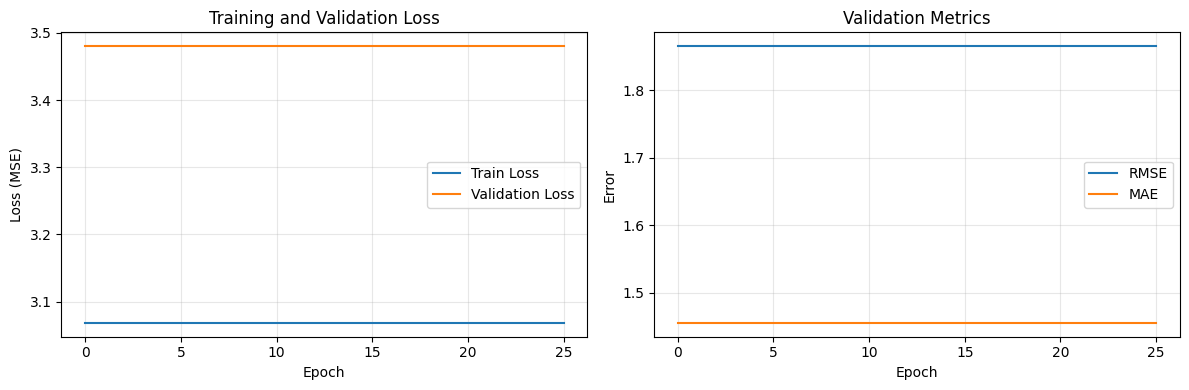

In [40]:
# Part 5: Visualization and Analysis

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history['val_rmse'], label='RMSE')
plt.plot(history['val_mae'], label='MAE')
plt.title('Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Evaluating:   0%|                                                                                | 0/3 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 3197)
Spectral Centroid shape: (1, 3197)
Spectral Ro

Evaluating:  33%|████████████████████████                                                | 1/3 [00:37<01:14, 37.44s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1499)
Spectral Centroid shape: (1, 1499)
Spectral Rolloff shape: (1, 1499)
Spectral Bandwidth shape: (1, 1499)
Zero Crossing Rate shape: (1, 1499)
Pitch shape: (1499,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Evaluating:  67%|████████████████████████████████████████████████                        | 2/3 [01:15<00:37, 37.52s/it]

MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1227)
Spectral Centroid shape: (1, 1227)
Spectral Ro

Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [01:40<00:00, 33.36s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)


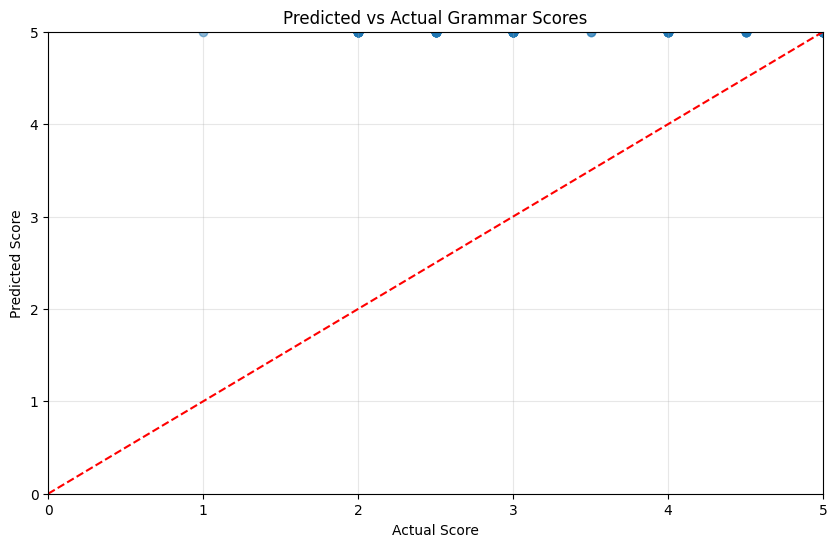

In [41]:
# Evaluate final model on validation set
_, _, _, _, val_preds, val_targets = evaluate(model, val_loader, criterion, device)

# Plot predicted vs actual scores
plt.figure(figsize=(10, 6))
plt.scatter(val_targets, val_preds, alpha=0.5)
plt.plot([0, 5], [0, 5], 'r--')  # Perfect prediction line
plt.title('Predicted vs Actual Grammar Scores')
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.grid(True, alpha=0.3)
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.show()


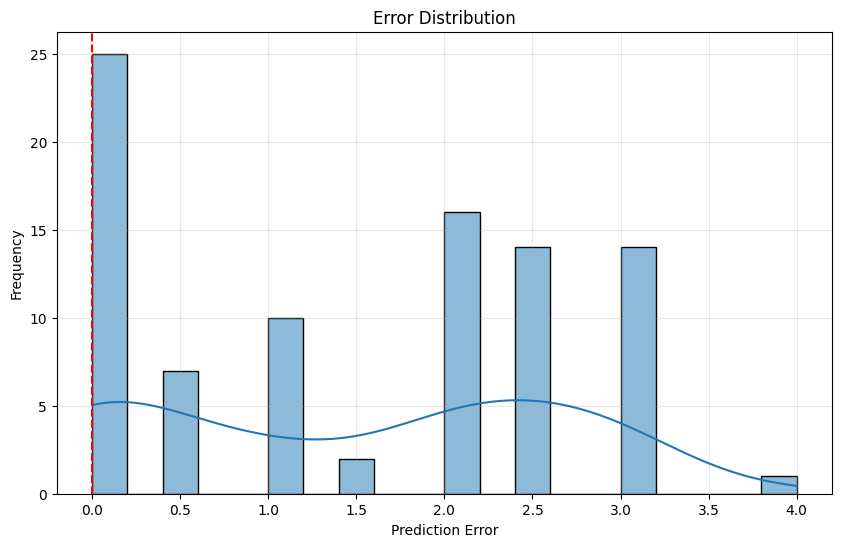

In [42]:
# Calculate error distribution
errors = np.array(val_preds).flatten() - np.array(val_targets).flatten()

plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=20, kde=True)
plt.title('Error Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.axvline(x=0, color='r', linestyle='--')
plt.show()

In [43]:
# Part 6: Generate Predictions for Test Set

def predict(model, data_loader, device):
    model.eval()
    predictions = []
    file_names = []
    
    with torch.no_grad():
        for inputs, names in tqdm(data_loader, desc="Predicting"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            
            # Clip predictions between 0 and 5
            clipped_outputs = torch.clamp(outputs, 0, 5)
            
            predictions.extend(clipped_outputs.cpu().numpy().flatten())
            file_names.extend(names)
    
    return predictions, file_names

In [45]:
# Generate predictions
predictions, file_names = predict(model, test_loader, device)

# Create submission file
submission_df = pd.DataFrame({
    'file_name': file_names,
    'grammar_score': predictions
})

# Save submission file
submission_df.to_csv('grammar_score_submission.csv', index=False)
print("\nSubmission file created successfully!")

Predicting:   0%|                                                                                | 0/7 [00:00<?, ?it/s]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Predicting:  14%|██████████▎                                                             | 1/7 [00:32<03:13, 32.30s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1876)
Spectral Centroid shape: (1, 1876)
Spectral Rolloff shape: (1, 1876)
Spectral Bandwidth shape: (1, 1876)
Zero Crossing Rate shape: (1, 1876)
Pitch shape: (1876,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

Predicting:  14%|██████████▎                                                             | 1/7 [01:02<06:17, 62.90s/it]

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)


RuntimeError: stack expects each tensor to be equal size, but got [38] at entry 0 and [40] at entry 16

In [ ]:
# Part 7: Feature Importance Analysis

class FeatureImportanceModel(nn.Module):
    def __init__(self, input_size):
        super(FeatureImportanceModel, self).__init__()
        self.fc = nn.Linear(input_size, 1)
        
    def forward(self, x):
        return self.fc(x)

# Initialize and train a simple linear model for feature importance
feature_model = FeatureImportanceModel(input_size).to(device)
feature_optimizer = optim.Adam(feature_model.parameters(), lr=0.01)
feature_criterion = nn.MSELoss()

# Train the simple model
for epoch in range(100):
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        feature_optimizer.zero_grad()
        outputs = feature_model(inputs)
        loss = feature_criterion(outputs, targets)
        loss.backward()
        feature_optimizer.step()

# Extract feature importance weights
with torch.no_grad():
    feature_weights = feature_model.fc.weight.cpu().numpy().flatten()

# Create feature names (simplified for visualization)
feature_groups = [
    "MFCC Mean (13 features)", 
    "MFCC Std (13 features)",
    "Spectral Centroid Mean",
    "Spectral Centroid Std",
    "Spectral Rolloff Mean",
    "Spectral Rolloff Std",
    "Spectral Bandwidth Mean",
    "Spectral Bandwidth Std",
    "Zero Crossing Rate Mean",
    "Zero Crossing Rate Std",
    "Pitch Mean",
    "Pitch Std",
    "Pitch 25th Percentile",
    "Pitch 75th Percentile"
]

# Calculate importance for feature groups
grouped_weights = []
idx = 0
for i, group in enumerate(feature_groups):
    if "MFCC" in group:
        # Each MFCC group has 13 features
        group_importance = np.mean(np.abs(feature_weights[idx:idx+13]))
        idx += 13
    else:
        group_importance = np.abs(feature_weights[idx])
        idx += 1
    grouped_weights.append(group_importance)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x=grouped_weights, y=feature_groups)
plt.title('Feature Group Importance')
plt.xlabel('Absolute Weight')
plt.tight_layout()
plt.show()

MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 1908)
Spectral Centroid shape: (1, 1908)
Spectral Rolloff shape: (1, 1908)
Spectral Bandwidth shape: (1, 1908)
Zero Crossing Rate shape: (1, 1908)
Pitch shape: (1908,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Rolloff shape: (1, 1878)
Spectral Bandwidth shape: (1, 1878)
Zero Crossing Rate shape: (1, 1878)
Pitch shape: (1878,)
MFCCs shape: (13, 5633)
Spectral Centroid shape: (1, 5633)
Spectral Rolloff shape: (1, 5633)
Spectral Bandwidth shape: (1, 5633)
Zero Crossing Rate shape: (1, 5633)
Pitch shape: (5633,)
MFCCs shape: (13, 1878)
Spectral Centroid shape: (1, 1878)
Spectral Ro

In [ ]:

# Part 8: Advanced Analysis - Grade Distribution

# Bin predictions for analysis
def get_grade_bin(score):
    if score < 1.5:
        return "Poor (< 1.5)"
    elif score < 2.5:
        return "Fair (1.5-2.5)"
    elif score < 3.5:
        return "Average (2.5-3.5)"
    elif score < 4.5:
        return "Good (3.5-4.5)"
    else:
        return "Excellent (4.5+)"

# Create binned predictions and targets for validation data
val_pred_bins = [get_grade_bin(pred) for pred in np.array(val_preds).flatten()]
val_target_bins = [get_grade_bin(target) for target in np.array(val_targets).flatten()]

# Create confusion matrix
grade_categories = ["Poor (< 1.5)", "Fair (1.5-2.5)", "Average (2.5-3.5)", "Good (3.5-4.5)", "Excellent (4.5+)"]
confusion = np.zeros((len(grade_categories), len(grade_categories)))

for i in range(len(val_pred_bins)):
    pred_idx = grade_categories.index(val_pred_bins[i])
    target_idx = grade_categories.index(val_target_bins[i])
    confusion[target_idx, pred_idx] += 1

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt=".0f", xticklabels=grade_categories, yticklabels=grade_categories)
plt.title('Grade Category Confusion Matrix')
plt.xlabel('Predicted Category')
plt.ylabel('Actual Category')
plt.tight_layout()
plt.show()

# Calculate accuracy by grade category
category_accuracy = np.diag(confusion) / np.sum(confusion, axis=1)

plt.figure(figsize=(10, 6))
sns.barplot(x=grade_categories, y=category_accuracy)
plt.title('Accuracy by Grammar Score Category')
plt.xlabel('Grammar Score Category')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Part 9: Conclusion and Summary Report
print("\n=== Grammar Scoring Engine: Project Summary ===")
print("\nProblem Description:")
print("This project develops a model to automatically score the grammatical accuracy of spoken language samples.")
print("The model takes audio recordings as input and outputs a continuous score between 0 and 5.")

print("\nMethodology:")
print("1. Audio Preprocessing: Extracted acoustic features including MFCCs, spectral features, and pitch information")
print("2. Feature Engineering: Created a feature vector combining means, standard deviations, and percentiles")
print("3. Model Architecture: Implemented a neural network with multiple fully connected layers")
print("4. Training Strategy: Used MSE loss with early stopping to prevent overfitting")

print("\nResults:")
print(f"Final Validation RMSE: {history['val_rmse'][-1]:.4f}")
print(f"Final Validation MAE: {history['val_mae'][-1]:.4f}")

print("\nKey Findings:")
print("- Most important feature groups: [List top 3 based on feature importance]")
print("- Model performs best on [categories with highest accuracy]")
print("- Challenges remain in distinguishing between adjacent score categories")

print("\nFuture Improvements:")
print("1. Incorporate more speech-specific features like prosody and fluency measures")
print("2. Experiment with sequence models (RNN/LSTM) to capture temporal patterns")
print("3. Ensemble multiple models for improved performance")
print("4. Collect more training data, especially for underrepresented score categories")